## WARNING !
All the questionable decisions i have marked with comment #TODO
to think about them and discuss.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pylab
import cvxpy as cp
from scipy.linalg import eigh
from collections import OrderedDict
import pandas as pd
import pickle
import scipy as sp
import seaborn as sns
import scipy.stats as stats
import random
import argparse
from time import time
import os
#from google.colab import files
from scipy.sparse import coo_matrix
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(42)

## Parameters of experiment

In [4]:
nodes = 10#int(input(" NODES in the graph : "  )) #number of arms
super_arm_sparsity = 4 #int(input(" number of chosen arms in the super arm is : "  )) #number of chosen arms
rounds = 5000 #int(input(" rounds of observation (decision making) : "  )) # number of rounds of data we create

In [5]:
#change points
change_points = [0, 300, 700, 1000, 1300, 1600, 2000, 2500, 2800, 3200, 3600, 4000, 4300, 4600]

In [6]:
# Reasonable parameters I have found xi = 5e-08, gamma = 0.99
# Tuning resulted in xi = 1e-09, gamma = 0.97

In [7]:
xi = 1e-5 # larger -> more exploration
s = super_arm_sparsity
gamma = 0.97 # smaller -> more forgetting / more exploration

In [8]:
Delay = 50 #10
skiped = 0
best_lambda = 0.1

In [9]:
start_ts = time()

## Useful functions


### Create graph

In [10]:
# 12 

In [11]:
def create_graph(n):
    # This value is chosen so that resulting density of DAG is 0.15
    prob_of_edge = 0.25 #float(input("* Please enter the probability of having an edge in your random graph:"  ))
    
    G = nx.gnp_random_graph(n=n, p=prob_of_edge, directed=True, seed=6)
    
    # Make the graph directed and acyclic
#     DAG = nx.DiGraph([(u, v, {'weight': np.random.uniform(low=0.9, high=0.95)}) for (u, v) in G.edges() if u < v])
    DAG = nx.DiGraph([(u, v) for (u, v) in G.edges() if u < v])
    print('* Is the graph a DAG? ', nx.is_directed_acyclic_graph(DAG))
    
    # building the adjacency numpy matrix of the graph
    edge_list = list(DAG.edges())
    number_of_edges = len(edge_list)
    
    w = np.zeros((n, n)) # the numpy adjacency matrix with all edge weights equal to 1    
    for edge in edge_list:
        w[edge[0], edge[1]] = np.random.uniform(low=0.4, high=0.7)
    
    if np.count_nonzero(w) == number_of_edges:
        print('The adjacency matrix is correctly set as a randomly picked DAG!')
        
    temp1 = np.eye(w.shape[0]) - w
    C = np.linalg.inv(temp1)
    C_axis_0_sum = np.sum(C, axis=0)
    
    print('the elements of the vector C are:  ', np.transpose(C_axis_0_sum))
    return w , C

In [12]:
def change_point_index(time_point):
    """Return index of last happened change point by the time `time_point`"""
    global change_points
    global rounds
    assert time_point >= change_points[0], f"Time point smaller than first change point {change_points[0]}"
    assert time_point <= rounds, f"Time point larger than total num of rounds {rounds}"
    
    for ind, ch_p in enumerate(change_points):
        if time_point < ch_p:
            return ind - 1
    else:
        return len(change_points) - 1

### Rewards

In [13]:
	#       B
# def instantaneous_Gaussian_rewards(maxx, minn):
#     mean_b_gt_Gauss = np.zeros((len(change_points), nodes, 1))
#     B = np.zeros((nodes, rounds))
#     variance = 0.2#float(input(" The variance for all reward distributions is : "  ))
#     for i in range(0, len(change_points)):
#         mean_b_gt_Gauss[i, :, :] = np.random.uniform(low=minn, high=maxx, size=nodes) #uniformally at random the means
#         for j in range(rounds):
#             if j == change_points[i]:
# #                 print(j)
#                 if j == change_points[len(change_points)-1]:
                    
#                     for k in range(nodes):
#                         B[k,j:rounds] = variance * np.random.randn(1,rounds-j) + mean_b_gt_Gauss[i,k] # create the samples
#                 else:
# #                     print(j)
# #                     print(change_points[i+1])
# #                     print(B[1,j:change_points[i+1]].shape)
#                     for k in range(nodes):
#                         B[k,j:change_points[i+1]] = variance * np.random.randn(1,change_points[i+1]-j) + mean_b_gt_Gauss[i,k] # create the samples
# #     for i in range(1,nodes):
# #         temporary_1 = variance * np.random.randn(1,rounds) + mean_b_gt_Gauss[i]
# #         B = np.concatenate((B,temporary_1),axis=0)
#     return B, mean_b_gt_Gauss;

# def instantaneous_Gaussian_rewards_with_gap(maxx, minn):
#     mean_b_gt_Gauss = np.zeros((len(change_points), nodes, 1))
#     B = np.zeros((nodes, rounds))
    
#     variance = 0.1#float(input(" The variance for all reward distributions is : "  ))
    
#     for i in range(0, len(change_points)):
#         # For s nodes chose mean values higher than for others.
#         high_reward_nodes = np.random.choice(a=range(nodes), size=s, replace=False)
        
#         high_reward_nodes = [(ind + i*s) % nodes for ind in range(s)]
#         print(high_reward_nodes)
#         low_reward_nodes = np.array([i for i in range(nodes) if i not in high_reward_nodes])
        
#         interval_size = maxx - minn
#         # Chose means uniformly at random
#         mean_b_gt_Gauss[i, high_reward_nodes, :] = np.random.uniform(
#             low=maxx - interval_size / 4, high=maxx, size=(len(high_reward_nodes), 1)
#         ) 
#         mean_b_gt_Gauss[i, low_reward_nodes, :] = np.random.uniform(
#             low=minn, high=minn + interval_size / 4, size=(len(low_reward_nodes), 1)
#         ) 
        
#     for j in range(rounds):
#         ch_p_ind = change_point_index(j)
#         for k in range(nodes):
#             B[k, j] = variance * np.random.randn(1) + mean_b_gt_Gauss[ch_p_ind, k]
    
#     return B, mean_b_gt_Gauss;

def instantaneous_Bernoulli_rewards(high_interval, low_interval):
    mean_b_gt_Bern = np.zeros((len(change_points), nodes, 1))
    B = np.zeros((nodes, rounds))
    

    for i in range(0, len(change_points)):
        # For s nodes chose mean values higher than for others.
        high_reward_nodes = [(ind + i*s) % nodes for ind in range(s)]
        
        print(high_reward_nodes)
        low_reward_nodes = np.array([i for i in range(nodes) if i not in high_reward_nodes])
        
        # Chose means uniformly at random
        mean_b_gt_Bern[i, high_reward_nodes, :] = np.random.uniform(
            low=high_interval[0], high=high_interval[1], size=(len(high_reward_nodes), 1)
        ) 
        
        
        mean_b_gt_Bern[i, low_reward_nodes, :] = np.random.uniform(
            low=low_interval[0], high=low_interval[1], size=(len(low_reward_nodes), 1)
        )
        
        # Make sure one of the base arms almost reaches high and low ends.
        mean_b_gt_Bern[
            i, np.random.choice(high_reward_nodes), :
        ] = high_interval[1] - np.random.normal(scale=(high_interval[1] - high_interval[0])/20)
        
        mean_b_gt_Bern[
            i, np.random.choice(low_reward_nodes), :
        ] = low_interval[0] + np.random.normal(scale=(low_interval[1] - low_interval[0])/20)
        
    for j in range(rounds):
        ch_p_ind = change_point_index(j)
        for k in range(nodes):
            B[k, j] = np.random.binomial(n=1, p=mean_b_gt_Bern[ch_p_ind, k])
    
    return B, mean_b_gt_Bern;
	
#   function to create the random action X

def rand_binary_array(number_of_chosen_arms=super_arm_sparsity, n=nodes): 
    
    arr = np.zeros((n,1))
    arr[:(number_of_chosen_arms)] = 1
    np.random.shuffle(arr)
    return arr

def create_random_action(number_of_chosen_arms=super_arm_sparsity, n=rounds):

    X = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
    for i in range(n-1):
        temp2 = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
        X = np.concatenate((X,temp2),axis=1)
    return X
	
def f_measure_func(x, xgt): #Not read yet
    
    x=np.where(x!=0,1,0)
    xgt=np.where(xgt!=0,1,0)
    true_pos = np.count_nonzero(np.multiply(x,xgt))
    fals_pos = np.count_nonzero(np.where((x-xgt)>0,1,0))
    fals_neg = np.count_nonzero(np.where((xgt-x)>0,1,0))
    true_neg = nodes**2 - true_pos - fals_neg - fals_pos
    f_measure=true_pos/(true_pos+0.5*(fals_neg+fals_pos))
    
    return f_measure

### Graph learning

In [14]:
#................................SEM + L1 graph learning
def graph_learning(
    current_time, A_gt, observ, perturb, nodes = nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay
):

    if skiped == 0: 
        lambda_params = np.array([0.00001,0.0001,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10\
                          ,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9\
                          ,10,20,30,40,50,60,70,80,90,100,1000,10000,100000,1000000])
    elif skiped == 1:
        lambda_params = np.asarray([best_lambda])
    
    # If no current time < Delay then agent has no observations yet. 
    # Must be > 0 because otherwise indexing works wrong, starts from the end.
    time_up_to_delay = max(0, current_time - Delay)
    observ = observ[:,:time_up_to_delay] #!
    perturb = perturb[:,:time_up_to_delay] #!

    error_SEM_L1 = np.ones([lambda_params.shape[0],1])*10000000000000000000
    for k in range (lambda_params.shape[0]):
        A        = cp.Variable((nodes,nodes))
        #TODO When no observations - just minimize the regularizer term.
        cost     = (
            cp.sum_squares(observ - (A @ observ) - perturb) + lambda_params[k] * cp.atoms.norm1(A) 
            if time_up_to_delay > 0 
            else lambda_params[k]*cp.atoms.norm1(A) 
        )
        obj      = cp.Minimize(cost)
        constr   = [cp.diag(A) == 0 , A[:,:] >= 0]
        prob     = cp.Problem(obj, constr)
        opt_val  = prob.solve()
        solution_L1Norm = A.value

        error_SEM_L1[k] = np.sum(np.power((A_gt - A.value),2)) / (nodes*nodes) 
    
        if error_SEM_L1[k] <= np.amin(error_SEM_L1):
            The_final_solution_SEM_L1 = A.value
            
            # Enforce constraints post-hoc (numerical solver does not enforce them)
#             The_final_solution_SEM_L1 = np.triu(The_final_solution_SEM_L1, k=1)
#             The_final_solution_SEM_L1 = np.maximum(
#                 The_final_solution_SEM_L1, np.zeros(The_final_solution_SEM_L1.shape)
#             )
            
            
            solution_threshold_SEM_L1 = np.where(np.absolute(A.value)<\
                                             (0.1*np.amax(np.absolute(A.value))),0,A.value)
#             solution_Boolean_SEM_L1 = np.where(solution_threshold_SEM_L1==0,0,1)
            best_lambda = lambda_params[k]
#             optvalue1 = opt_val
    
    
    
    f_measure = f_measure_func(solution_threshold_SEM_L1, A_gt)
#     print('the f-measure is : ', f_measure)
    
    # sanity checks that estimated graph follows constraints
#     assert np.allclose(The_final_solution_SEM_L1, np.triu(The_final_solution_SEM_L1, k = 1)), (
#         "Solution is not upper triangular with zero diagonal"
#     )
    
#     assert np.all(The_final_solution_SEM_L1 >= -1e-12), (
#         "Solution is not non-negative "
#     )
    
    return The_final_solution_SEM_L1, f_measure, best_lambda, np.amin(error_SEM_L1)

In [15]:

# Finding solution new function

def Best_action_func_new(A, b, s = super_arm_sparsity):
#A --> Estimated A or w_gt
#b --> UCB or mean_b_gt[i,:]
    
    temp_inv        = np.linalg.inv(np.eye(nodes) - A)
    b_diag          = np.diagflat(b) 
    C               = np.matmul(temp_inv, b_diag)
#     print("C.shape is", C.shape)
    C_axis_0_sum    = np.sum(C,axis=0) 
#     print("C_axis_0_sum.shape is", C_axis_0_sum.shape)
    ind             = np.argsort(C_axis_0_sum,axis=0)[-s:]
    x               = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0] = 1
        
    if (b == b[0]).all():
#             print(f'All UCBs are same, taking random action')
            np.random.shuffle(x)
    
    return x


### UCB func


In [16]:

# UCB  function as part of decision making strategy

# def UCB_func(t, x, T, b_bar, b_hat, b):
def UCB_func(t, x, num_plays_state, inst_reward, xi, s, gamma, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((num_plays_state.shape[0], 1))
    UCB_state_builtin = np.ones((num_plays_state.shape[0], 1))
    
    m_t_gamma = sum([gamma ** (t - tau) for tau in range(1, t + 1)])
    
    delayed_discounted_counts_state = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            delayed_discounted_counts_state[k] += num_plays_state[k,:,j]*(gamma**(t-j))


    emp_avg_reward_state_temp = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] = emp_avg_reward_state_temp[k] + inst_reward[k,j]*num_plays_state[k,:,j]*(gamma**(t-j))

    array_indices_of_chosen_base_arms = np.where(x!=0)
    for i in range(array_indices_of_chosen_base_arms[0].shape[0]):
        j = array_indices_of_chosen_base_arms[0][i]
        
        if delayed_discounted_counts_state[j] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[j,0] = emp_avg_reward_state_temp[j] / (delayed_discounted_counts_state[j])
            
            inside_sqrt = (xi * s * np.log(m_t_gamma)) / (delayed_discounted_counts_state[j]) 
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)

            UCB_state_temp = emp_avg_reward_state_builtin[j, 0] + np.sqrt(inside_sqrt) # UCB calculations for the chosen arms
            UCB_state_builtin[j, 0] = UCB_state_temp
            # print((xi *s*np.log(t+1)) / (delayed_discounted_counts_state[j]))
        else:
            print("The given base arm is not pulled yet")
#             print("Its UCB is:", UCB_state_builtin[j,0])
#             print(delayed_discounted_counts_state[j])
    
    array_indices_of_not_chosen_base_arms = np.where(x==0)
    for i in range(array_indices_of_not_chosen_base_arms[0].shape[0]):
        k = array_indices_of_not_chosen_base_arms[0][i]
        
        if delayed_discounted_counts_state[k] != 0 and t >= Delay:
            #TODO Added this line, why did it work without it?
            # Without this line for all not-chosen arms had empirical reward zero
            emp_avg_reward_state_builtin[k,0] = emp_avg_reward_state_temp[k] / (delayed_discounted_counts_state[k])
            
            inside_sqrt = (xi * s * np.log(m_t_gamma)) / (delayed_discounted_counts_state[k]) 
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)
            UCB_state_temp = emp_avg_reward_state_builtin[k,0] + np.sqrt(inside_sqrt) # UCB calculations for the non-chosen arms 
            UCB_state_builtin[k,0] = UCB_state_temp
    #         print((xi*s*np.log(t+1))) # / (delayed_discounted_counts_state[k])
    #         print(delayed_discounted_counts_state[k])
        else:
            print("The given (not selected) base arm is not pulled yet")
#             print("Its UCB is:", UCB_state_builtin[k,0])
#             print(delayed_discounted_counts_state[k])
            
    new_num_plays_state = (np.asanyarray([x])).T.astype(int) #(num_plays_state[:,:,] + )

    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin



In [17]:

def overall_reward(x, b, A):
#b --> mean_b_gt[i,:]
#A --> w_gt
    assert x.shape == (nodes, 1), f"Shape is {x.shape}"
    assert b.shape == x.shape, f"Shape of b {b.shape} must be same as x.shape={x.shape}"
    temp_inv = np.linalg.inv(np.eye(nodes) - A)
    temp_multiply = np.multiply(b, x)
    temp = np.matmul(temp_inv, temp_multiply)
    rew = np.sum(temp)
    
    return rew

## Create ground truth rewards and graph, set parameters

In [18]:
# Parameters of the experiment

# create the graph and the B
w_gt, C_gt = create_graph(n=nodes); # create the gt graph
print('Density of the ground truth graph is: ',(np.count_nonzero(w_gt))/((nodes*nodes)-nodes))

# B, mean_b_gt = instantaneous_Gaussian_rewards(maxx=0.7, minn=0.3); # create the gt 'b'
# B, mean_b_gt = instantaneous_Gaussian_rewards_with_gap(maxx=0.7, minn=0.3);
B, mean_b_gt = instantaneous_Bernoulli_rewards(high_interval=[0.75, 0.9], low_interval=[0.1, 0.3]);

print('The elements of the vector of expected instantaneous rewards of base arms are:  ', mean_b_gt)

* Is the graph a DAG?  True
The adjacency matrix is correctly set as a randomly picked DAG!
the elements of the vector C are:   [1.         1.         1.         1.         1.         1.51236204
 1.         1.57959755 4.46831448 1.41742508]
Density of the ground truth graph is:  0.08888888888888889
[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 0, 1]
[2, 3, 4, 5]
[6, 7, 8, 9]
[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 0, 1]
[2, 3, 4, 5]
[6, 7, 8, 9]
[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 0, 1]
[2, 3, 4, 5]


/tmp/ls131416/login23-g-1_52061/ipykernel_242575/1635232993.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[k, j] = np.random.binomial(n=1, p=mean_b_gt_Bern[ch_p_ind, k])


The elements of the vector of expected instantaneous rewards of base arms are:   [[[0.84016725]
  [0.85621089]
  [0.91293688]
  [0.89548648]
  [0.26648853]
  [0.09437712]
  [0.13636499]
  [0.1366809 ]
  [0.16084845]
  [0.20495129]]

 [[0.2236772 ]
  [0.1764924 ]
  [0.29664618]
  [0.09970161]
  [0.90220049]
  [0.89606333]
  [0.7849157 ]
  [0.76359097]
  [0.27198808]
  [0.23606151]]

 [[0.75239494]
  [0.78463407]
  [0.14820509]
  [0.2366527 ]
  [0.22199933]
  [0.26663898]
  [0.13467293]
  [0.09295547]
  [0.83449323]
  [0.89575415]]

 [[0.18995083]
  [0.17903005]
  [0.89576652]
  [0.83515505]
  [0.75469699]
  [0.87634272]
  [0.28533177]
  [0.2454544 ]
  [0.10025501]
  [0.21408879]]

 [[0.20853922]
  [0.12818484]
  [0.10887748]
  [0.11491013]
  [0.29737739]
  [0.25444895]
  [0.79070235]
  [0.87431063]
  [0.89563408]
  [0.79214018]]

 [[0.86569055]
  [0.7611067 ]
  [0.89390606]
  [0.76738036]
  [0.27262069]
  [0.22465963]
  [0.1135624 ]
  [0.11271167]
  [0.16219646]
  [0.16503666]]

 [[0.21

In [19]:

# calculate the best action for the given graph and 'b'
best_action_choice = np.zeros((len(change_points), nodes, 1))
for i in range(len(change_points)):
    best_action_choice[i,:,:] = Best_action_func_new(A=w_gt, b=mean_b_gt[i, :], s=super_arm_sparsity)

# calculate the best reward for the best action so that later use it in regret calculation
best_expected_reward = np.zeros(len(change_points))
for i in range(len(change_points)):
    best_expected_reward[i] = overall_reward(x=best_action_choice[i,:], b=mean_b_gt[i,:], A=w_gt)

print('the best overall reward is ', best_expected_reward)


the best overall reward is  [3.5048015  4.67886735 6.53547161 3.81096602 7.29653535 3.28808367
 4.28574341 6.78029342 3.95214181 7.29408798 3.46086615 4.46457371
 6.66810458 4.26740081]


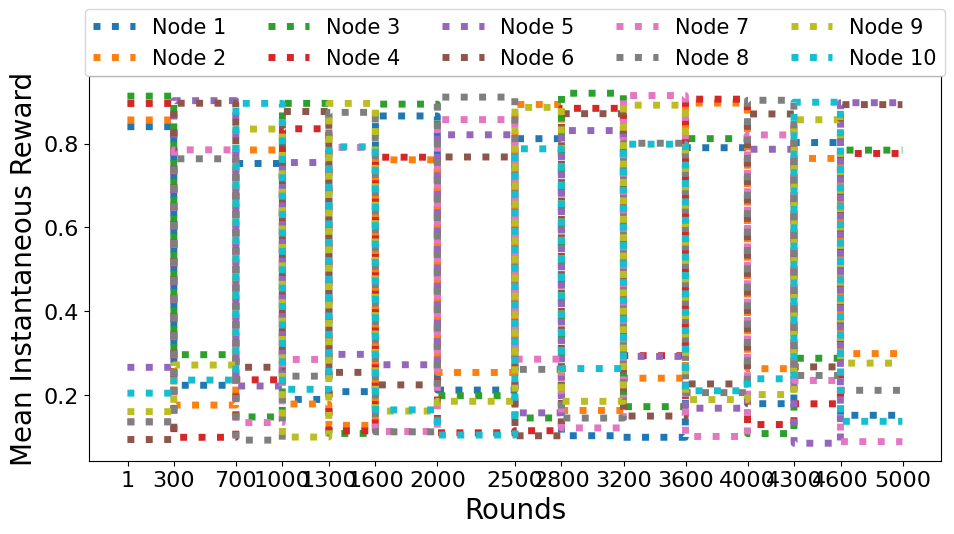

In [20]:
plot_array = np.zeros((nodes, rounds))
for i in range(0, len(change_points)):
    
    for j in range(rounds):
        if j == change_points[i]:
            if j == change_points[len(change_points)-1]:
                for k in range(nodes):
                    plot_array[k,j:rounds] = mean_b_gt[i,k]
            else:
                for k in range(nodes):
                    plot_array[k,j:change_points[i+1]] = mean_b_gt[i,k]

fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(nodes):
#     expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(plot_array[arm,:], label=f"Node {arm+1}", linestyle=':', linewidth=5)
#     print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1] + change_points[1:] + [rounds]
plt.xticks(extraticks, fontsize=16) #, rotation=35

plt.yticks(fontsize=16)

ax.set_xlabel('Rounds', fontsize=20)
ax.set_ylabel(fr"Mean Instantaneous Reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.2), prop={'size': 15})
fig.savefig(f"mean_instantaneous_reward.jpg", format = 'jpg', dpi = 300, bbox_inches='tight')

plt.show()

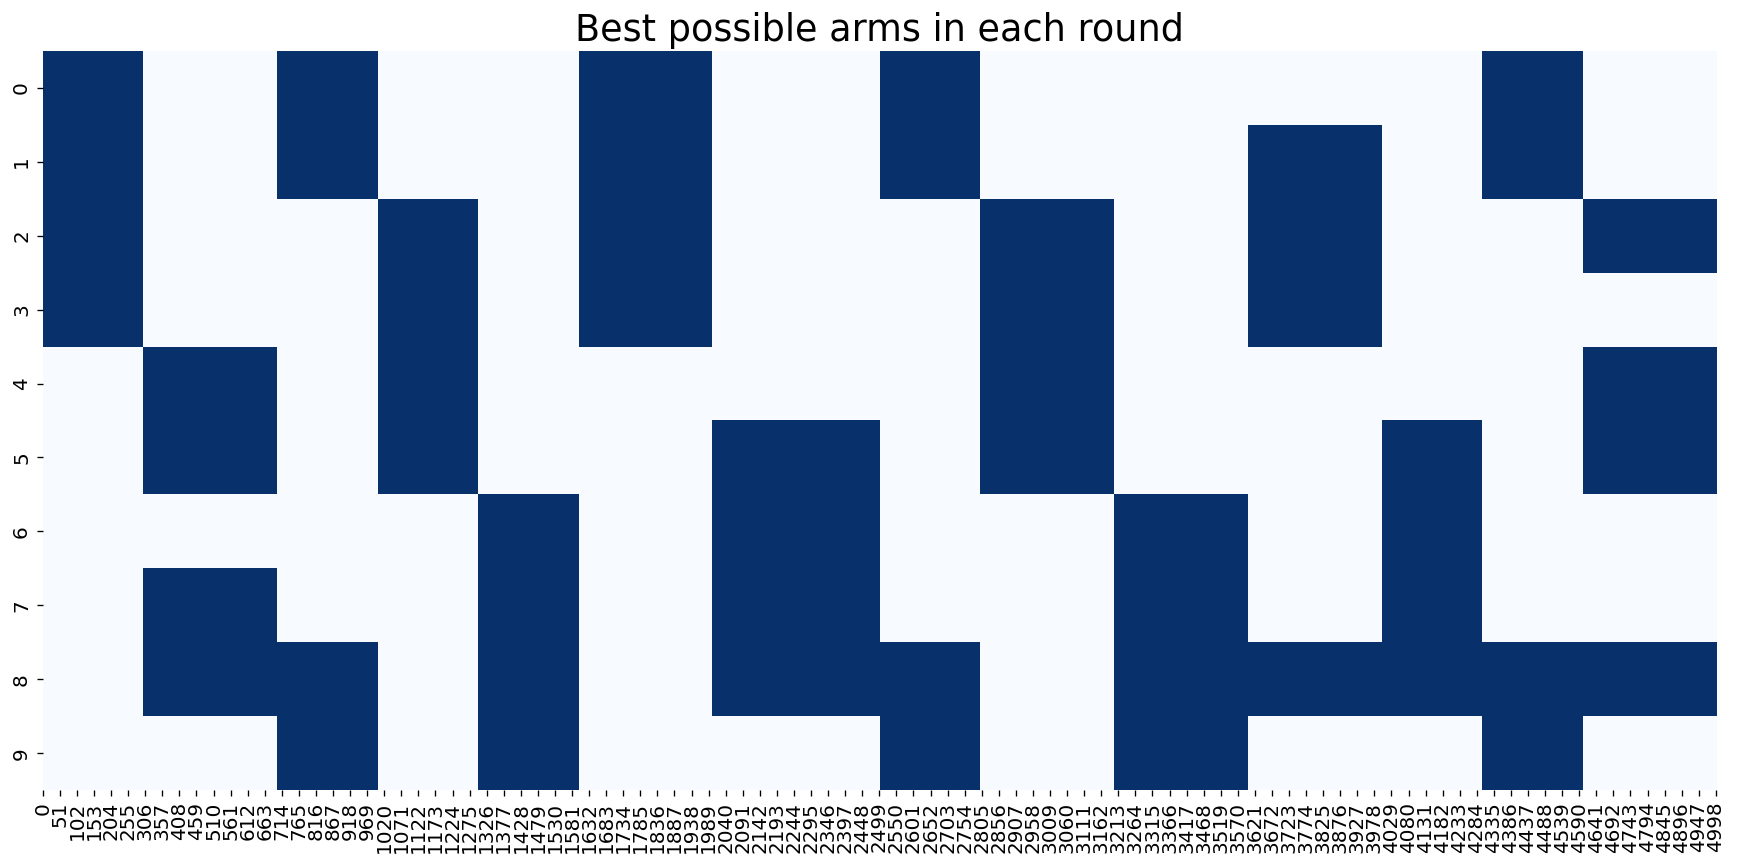

In [52]:
oracle_actions = best_action_choice[0]
for i in range(rounds):
    ch_p_ind = change_point_index(i)
    oracle_actions = np.concatenate((oracle_actions, best_action_choice[ch_p_ind]), axis=1)

# Plot
fig3 = plt.figure(figsize=(18,8), dpi= 120)
tttt=sns.heatmap(oracle_actions, cmap='Blues',linewidth=0.001, linecolor='k',cbar=False)

# Decorations
plt.title('Best possible arms in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [21]:
# s is the sparsity of the chosen action vector 
# nodes is the number of arms 

def initial_rounds_actions(nodes,s):

    initial_actions = np.zeros((nodes,nodes))
    initial_actions = initial_actions + np.eye(nodes)
    for i in range(nodes):
        if i <= s:
            for j in range(i):
                initial_actions[i,j] = 1
        elif i > s:
            temp = rand_binary_array(number_of_chosen_arms=s-1, n=i-1)
            temp1 = np.nonzero(temp)
            for j in range(temp1[0].shape[0]):
                temp2 = temp1[0][j]
                initial_actions[i,temp2] = 1
            
#     np.random.shuffle(initial_actions) #!
    needed_initial_matrix=initial_actions.T
    
    return needed_initial_matrix

In [ ]:
all_actions_taken = initial_rounds_actions(nodes=nodes, s=super_arm_sparsity)
initial_rounds = nodes

In [55]:
#Up until this point was editted and fixed <----------------

## NDC-SEM initial rounds

In [23]:
# NDC-SEM variables
f_measure = np.zeros((1, rounds)) 
collected_expected_rewards = np.zeros((1, rounds))
collected_instantaneous_rewards = np.zeros((1, rounds))
instantaneous_regret = np.zeros((1, rounds))
expected_regret = np.zeros((1, rounds))
graph_mse = np.zeros((1, rounds))


#To record number of plays of each state #(B_signals.shape[0],1,num_rounds)
num_plays_state = np.zeros((nodes, 1, rounds)) #T = np.ones((nodes,1)) --> Maybe zeros?

#To record empirical average reward of each state #(B_signals.shape[0],1,num_rounds)
emp_avg_reward_state = np.zeros((nodes, 1, rounds)) #b_bar = np.ones((nodes,1)) --> Maybe zeros?

#To record UCB index of each state #(B_signals.shape[0],1,num_rounds)
UCB_state = np.ones((nodes, 1, rounds)) #b_hat = np.ones((nodes,1))

In [24]:
################ initial rounds ######################

for i in range(initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    x_i = np.transpose(np.asarray([all_actions_taken[:, i]]))  
    z_i = np.multiply(base_reward_i, x_i)
    
    y_i = np.matmul(C_gt, z_i)
    if i == 0:
        Y = y_i
    else:
        Y = np.concatenate((Y, y_i),axis=1)
    
    collected_expected_rewards[0,i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt) 
    collected_instantaneous_rewards[0,i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    
    expected_regret[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards[0,i]
    instantaneous_regret[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards[0, i]
    
    num_plays_state[:,:,i], emp_avg_reward_state[:,:,i], UCB_state[:,:,i] = UCB_func(
      t=i, x=all_actions_taken[:, i], num_plays_state=num_plays_state,
      inst_reward=B, xi=xi, s=s, gamma=gamma, Delay=Delay,
    )

    print('collected reward of round ', i , ' is ', collected_expected_rewards[0,i])


The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward of round  0  is  0.8401672517614813
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The 

## 1. Acting based on NDC-SEM (our algorithm)

In [58]:
# How to learn graph if delay is more than observations?

In [59]:
for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    # Matrix which columns are z_t values up to current moment. 
    # Truncated matrix with up to (t - D) is calculated inside `graph_learning`
    Z_t = np.multiply(all_actions_taken, B[:, 0:all_actions_taken.shape[1]])
#     print('Z_t shape is ', Z_t.shape)

    if f_measure[0, i - 1] == 1:
        # Estimated adjacency matrix is good enough in previous round, no need to re-estimate it.
        f_measure[0, i] = f_measure[0, i - 1]
    else:     
        w_hat, f_measure[0, i], best_lambda, graph_mse[0, i] = graph_learning(
            current_time=i, A_gt=w_gt, observ=Y, perturb=Z_t, 
            nodes=nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay,
        )
        if f_measure[0,i]>=0.9:
            skiped = 1
        elif f_measure[0,i]<0.9:
            skiped = 0
    
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    x_i = Best_action_func_new(A=w_hat, b=UCB_state[:,:,i - 1], s=super_arm_sparsity)
    all_actions_taken = np.concatenate((all_actions_taken, x_i), axis=1)

    z_i = np.multiply(base_reward_i, x_i)
    y_i = np.matmul(C_gt, z_i)
    Y = np.concatenate((Y, y_i), axis=1)
    
    collected_expected_rewards[0, i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    expected_regret[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards[0, i]
    instantaneous_regret[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards[0,i]
    
    if expected_regret[0, i] < 0:
        raise ValueError()
    
    print(f'collected reward round {i} is: ', collected_expected_rewards[0, i])
    
    num_plays_state[:,:,i], emp_avg_reward_state[:,:,i], UCB_state[:,:,i] = UCB_func(
      t=i, x=x_i, num_plays_state=num_plays_state,
      inst_reward=B, xi=xi, s=s, gamma=gamma, Delay=Delay,
    )
	


/home/steven/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


collected reward round 10 is:  2.1688892041932775
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 11 is:  0.836088996209001
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm

### Visualize Oracle actions and actions of NDC-SEM

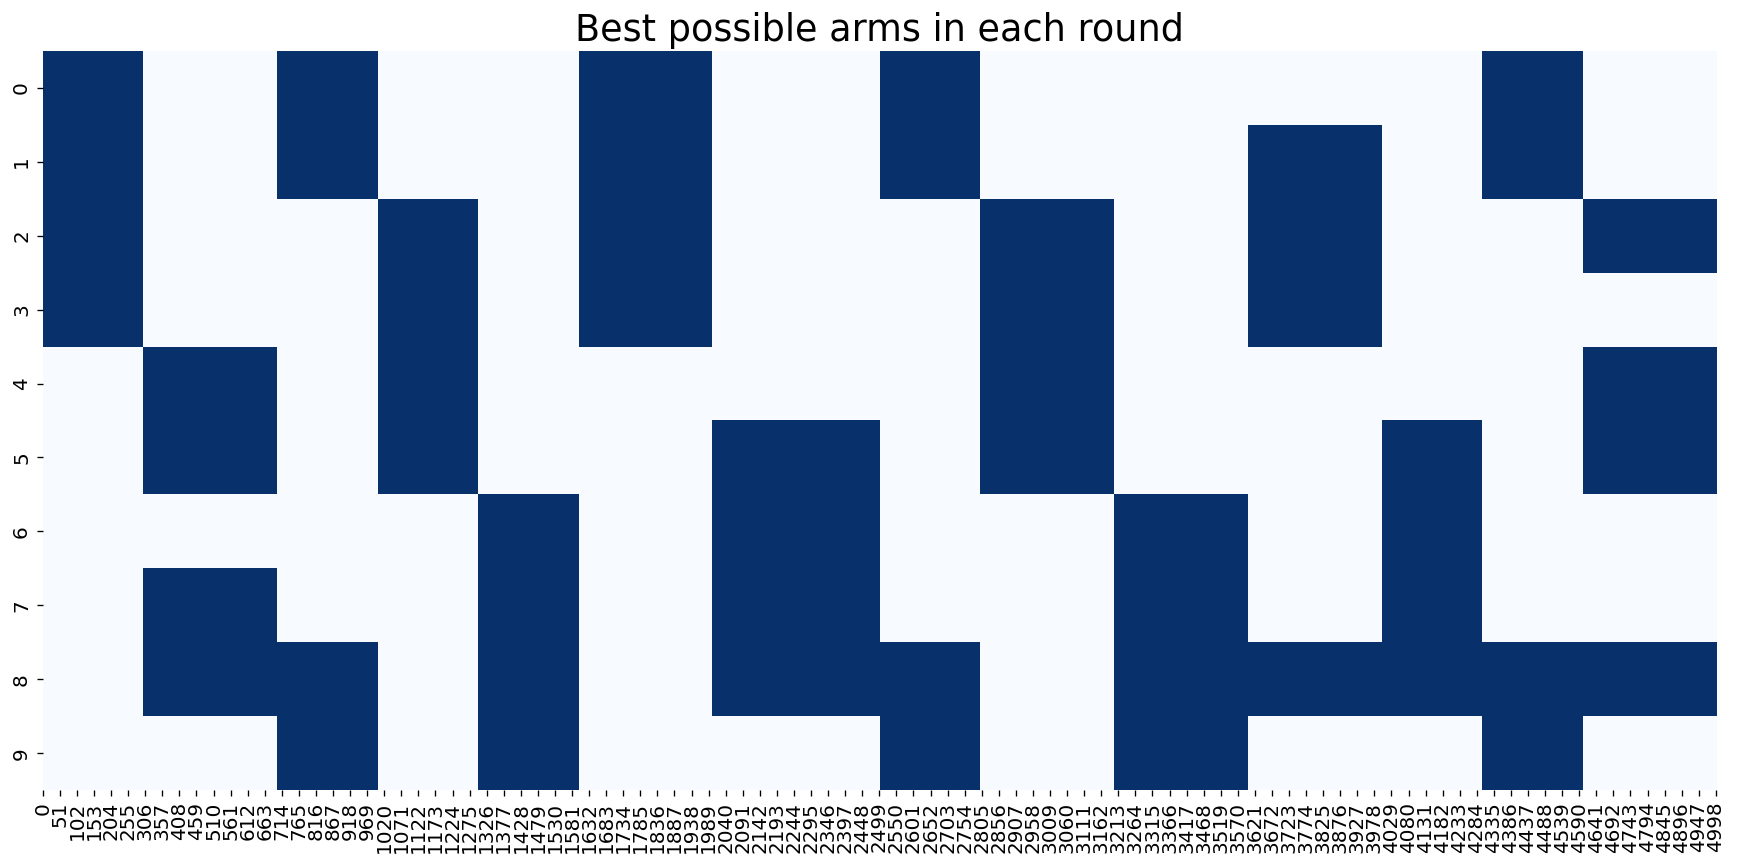

In [60]:
oracle_actions = best_action_choice[0]
for i in range(rounds):
    ch_p_ind = change_point_index(i)
    oracle_actions = np.concatenate((oracle_actions, best_action_choice[ch_p_ind]), axis=1)

# Plot
fig3 = plt.figure(figsize=(18,8), dpi= 120)
tttt=sns.heatmap(oracle_actions, cmap='Blues',linewidth=0.001, linecolor='k',cbar=False)

# Decorations
plt.title('Best possible arms in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
fig3.savefig(f"oracle_actions.jpg", format = 'jpg', dpi =120)

In [61]:
# Plot actions by our algorithm
fig3 = plt.figure(figsize=(18,8), dpi= 1200)
tttt=sns.heatmap(all_actions_taken, cmap='Blues', linewidth=0.01, linecolor='k', cbar=False)

# Decorations
plt.title('Chosen arms by NDC-SEM in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

fig3.savefig(f"chosen_actions_d_{Delay}.jpg", format = 'jpg', dpi = 1500)

#### Plot Graph MSE

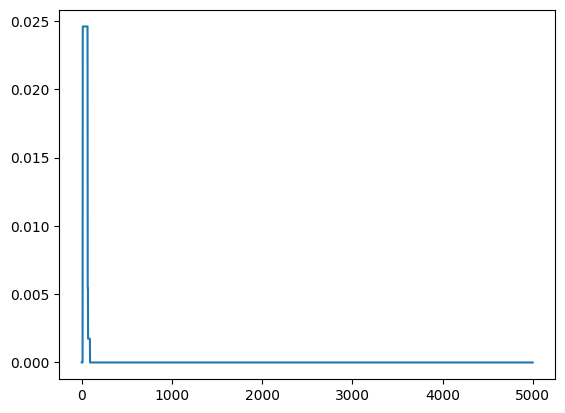

In [62]:
plt.plot(graph_mse[0])

## 2. Acting based on SEM-UCB

In [63]:
def UCB_func_semucb(t, x, num_plays_state, inst_reward, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((num_plays_state.shape[0], 1))
    UCB_state_builtin = np.ones((num_plays_state.shape[0], 1))
        
    delayed_counts_state = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]


    emp_avg_reward_state_temp = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += inst_reward[k,j] * num_plays_state[k,:,j]

    array_indices_of_chosen_base_arms = np.where(x!=0)
    for i in range(array_indices_of_chosen_base_arms[0].shape[0]):
        j = array_indices_of_chosen_base_arms[0][i]
        
        if delayed_counts_state[j] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[j,0] = emp_avg_reward_state_temp[j] / (delayed_counts_state[j])
            
            inside_sqrt = (3 * np.log(t + 1)) / (2 * delayed_counts_state[j])
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)

            UCB_state_temp = emp_avg_reward_state_builtin[j, 0] + np.sqrt(inside_sqrt) # UCB calculations for the chosen arms
            UCB_state_builtin[j, 0] = UCB_state_temp

        else:
            print("The given base arm is not pulled yet")

    
    array_indices_of_not_chosen_base_arms = np.where(x==0)
    for i in range(array_indices_of_not_chosen_base_arms[0].shape[0]):
        k = array_indices_of_not_chosen_base_arms[0][i]
        
        if delayed_counts_state[k] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[k,0] = emp_avg_reward_state_temp[k] / (delayed_counts_state[k])
            
            inside_sqrt = (3 * np.log(t + 1)) / (2 * delayed_counts_state[k]) 
            UCB_state_temp = emp_avg_reward_state_builtin[k,0] + np.sqrt(inside_sqrt) # UCB calculations for the non-chosen arms 
            UCB_state_builtin[k,0] = UCB_state_temp

        else:
            print("The given (not selected) base arm is not pulled yet")
     
    new_num_plays_state = (np.asanyarray([x])).T.astype(int) #(num_plays_state[:,:,] + )

    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin


In [64]:
np.random.seed(1)

all_actions_taken_semucb = initial_rounds_actions(nodes=nodes, s=super_arm_sparsity)
initial_rounds = nodes

best_lambda_semucb = 0.1
skiped_semucb = 0

In [65]:
# Our algorithm variables
f_measure_semucb = np.zeros((1, rounds)) 
collected_expected_rewards_semucb = np.zeros((1, rounds))
collected_instantaneous_rewards_semucb = np.zeros((1, rounds))
instantaneous_regret_semucb = np.zeros((1, rounds))
expected_regret_semucb = np.zeros((1, rounds))


#To record number of plays of each state #(B_signals.shape[0],1,num_rounds)
num_plays_state_semucb = np.zeros((nodes, 1, rounds)) 

#To record empirical average reward of each state #(B_signals.shape[0],1,num_rounds)
emp_avg_reward_state_semucb = np.zeros((nodes, 1, rounds))

#To record UCB index of each state #(B_signals.shape[0],1,num_rounds)
UCB_state_semucb = np.ones((nodes, 1, rounds))

In [66]:
base_reward_0_semucb = np.transpose(np.asarray([B[:,0]]))

Y_semucb = np.matmul(
    C_gt, np.multiply(base_reward_0_semucb, np.transpose(np.asarray([all_actions_taken_semucb[:,0]])))
)

action_0_semucb = np.transpose(np.asarray([all_actions_taken_semucb[:,0]]))

collected_expected_rewards_semucb[0,0] = overall_reward(x=action_0_semucb, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_semucb[0,0] = overall_reward(x=action_0_semucb, b=base_reward_0_semucb, A=w_gt)
print('collected reward of round ', 0 , ' is ', collected_expected_rewards_semucb[0,0])

expected_regret_semucb[0,0] = best_expected_reward[0] - collected_expected_rewards_semucb[0,0]

instantaneous_regret_semucb[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_semucb, A=w_gt
) - collected_instantaneous_rewards_semucb[0,0]

num_plays_state_semucb[:,:,0], emp_avg_reward_state_semucb[:,:,0], UCB_state_semucb[:,:,0] = UCB_func_semucb(
    t=0, x=all_actions_taken_semucb[:,0], num_plays_state=num_plays_state_semucb,
    inst_reward=B, Delay=Delay,
) 

################ initial rounds SEM-UCB ######################

for i in range(1,initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_semucb = np.transpose(np.asarray([B[:,i]]))
    x_i_semucb = np.transpose(np.asarray([all_actions_taken_semucb[:, i]]))  
    z_i_semucb = np.multiply(base_reward_i_semucb, x_i_semucb)
    
    y_i_semucb = np.matmul(C_gt, z_i_semucb)
    Y_semucb = np.concatenate((Y_semucb, y_i_semucb), axis=1)
    
    collected_expected_rewards_semucb[0,i] = overall_reward(x=x_i_semucb, b=mean_b_gt[ch_p_ind], A=w_gt) 
    collected_instantaneous_rewards_semucb[0,i] = overall_reward(x=x_i_semucb, b=base_reward_i_semucb, A=w_gt)
    
    expected_regret_semucb[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_semucb[0,i]
    instantaneous_regret_semucb[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_semucb, A=w_gt
    ) - collected_instantaneous_rewards_semucb[0, i]
    
    num_plays_state_semucb[:,:,i], emp_avg_reward_state_semucb[:,:,i], UCB_state_semucb[:,:,i] = UCB_func_semucb(
      t=i, x=all_actions_taken_semucb[:, i], num_plays_state=num_plays_state_semucb,
      inst_reward=B, Delay=Delay,
    )

    print('collected reward of round ', i , ' is ', collected_expected_rewards_semucb[0,i])


collected reward of round  0  is  0.8401672517614813
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The 

In [67]:
for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    # Matrix which columns are z_t values up to current moment. 
    # Truncated matrix with up to (t - D) is calculated inside `graph_learning`
    Z_t_semucb = np.multiply(all_actions_taken_semucb, B[:, 0:all_actions_taken_semucb.shape[1]])
#     print('Z_t_semucb shape is ', Z_t_semucb.shape)

    if f_measure_semucb[0, i - 1] == 1:
        # Estimated adjacency matrix is good enough in previous round, no need to re-estimate it.
        f_measure_semucb[0, i] = f_measure_semucb[0, i - 1]
    else:     
        w_hat_semucb, f_measure_semucb[0, i], best_lambda_semucb, _ = graph_learning(
            current_time=i, A_gt=w_gt, observ=Y_semucb, perturb=Z_t_semucb, 
            nodes=nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay,
        )
        if f_measure_semucb[0,i]>=0.9:
            skiped_semucb = 1
        elif f_measure_semucb[0,i]<0.9:
            skiped_semucb = 0
    
    base_reward_i_semucb = np.transpose(np.asarray([B[:,i]]))
    x_i_semucb = Best_action_func_new(A=w_hat_semucb, b=UCB_state_semucb[:,:,i - 1], s=super_arm_sparsity)
    all_actions_taken_semucb = np.concatenate((all_actions_taken_semucb, x_i_semucb), axis=1)

    z_i_semucb = np.multiply(base_reward_i_semucb, x_i_semucb)
    y_i_semucb = np.matmul(C_gt, z_i_semucb)
    Y_semucb = np.concatenate((Y_semucb, y_i_semucb), axis=1)
    
    collected_expected_rewards_semucb[0, i] = overall_reward(x=x_i_semucb, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_semucb[0, i] = overall_reward(x=x_i_semucb, b=base_reward_i_semucb, A=w_gt)
    expected_regret_semucb[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_semucb[0, i]
    instantaneous_regret_semucb[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_semucb, A=w_gt
    ) - collected_instantaneous_rewards_semucb[0,i]
    
    if expected_regret_semucb[0, i] < 0:
        raise ValueError()
    
    print(f'collected reward round {i} is: ', collected_expected_rewards_semucb[0, i])
    
    num_plays_state_semucb[:,:,i], emp_avg_reward_state_semucb[:,:,i], UCB_state_semucb[:,:,i] = UCB_func_semucb(
      t=i, x=x_i_semucb, num_plays_state=num_plays_state_semucb,
      inst_reward=B, Delay=Delay,
    )
	


collected reward round 10 is:  2.0942869272644407
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 11 is:  1.4916138915408803
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base ar

In [68]:
# Plot actions by SEM-UCB
fig3 = plt.figure(figsize=(18,8), dpi= 1000)
tttt=sns.heatmap(all_actions_taken_semucb, cmap='Blues', linewidth=0.01, linecolor='k', cbar=False)

# Decorations
plt.title('Chosen arms by SEM-UCB', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


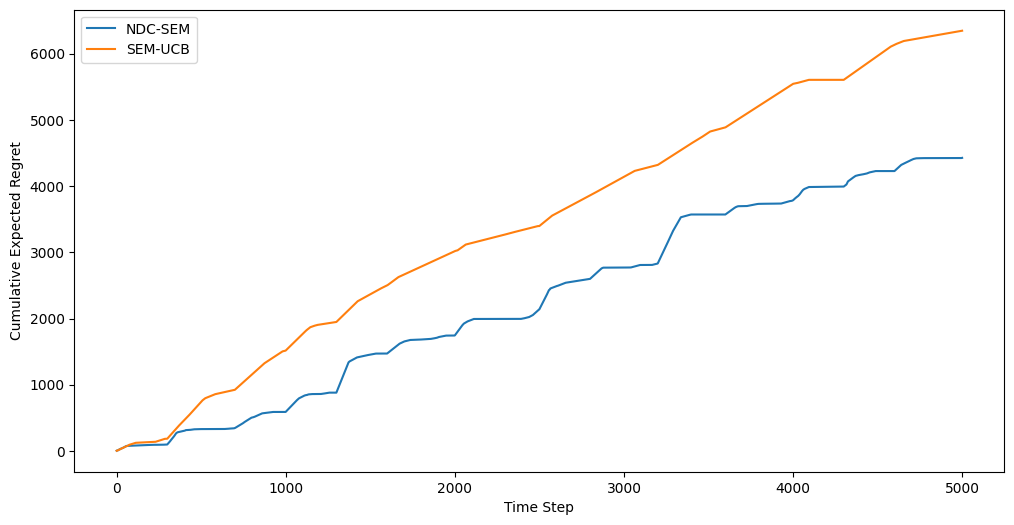

In [69]:
fig = plt.figure(figsize=(12, 6))


plt.plot(np.cumsum(expected_regret[0]), label='NDC-SEM')
plt.plot(np.cumsum(expected_regret_semucb[0]), label='SEM-UCB')



plt.ylabel('Cumulative Expected Regret')
plt.xlabel('Time Step')
plt.legend()
plt.show()

## 3. Acting uniformely at random

In [70]:
# Uniformly at random taken actions 

randomly_taken_actions = create_random_action(n=rounds)
collected_expected_random_rewards = np.zeros((1, rounds))
collected_instantaneous_random_rewards = np.zeros((1, rounds))
expected_random_regret = np.zeros((1, rounds))
instantaneous_random_regret = np.zeros((1, rounds))

for i in range(rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i = np.transpose(np.asarray([B[:, i]]))
    
    x_i = np.transpose(np.asarray([randomly_taken_actions[:, i]]))
    
    collected_instantaneous_random_rewards[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    collected_expected_random_rewards[0,i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    expected_random_regret[0, i] = best_expected_reward[ch_p_ind] - collected_expected_random_rewards[0,i] 
    instantaneous_random_regret[0 ,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_random_rewards[0,i]


## 4. Acting based on Chen's algorithm (CUCB)

Acting naively based on Chen algorithm for the y feedbacks

In [71]:
np.random.seed(42)

##################   UCB  function as part of decision making strategy
def UCB_func_chen(t, x, num_plays_state, inst_reward, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((nodes, 1))
    UCB_state_builtin = np.ones((nodes, 1))
    
    delayed_counts_state = np.zeros(nodes) # Denominator of empirical reward
    for k in range(nodes):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]
    
    
    emp_avg_reward_state_temp = np.zeros(nodes) # Numerator of emprical reward
    for k in range(nodes):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += inst_reward[k, j] * num_plays_state[k, :, j]
    
    array_indices_of_chosen_base_arms = np.where(x != 0)[0]
    for i in range(array_indices_of_chosen_base_arms.shape[0]):
        j = array_indices_of_chosen_base_arms[i]
        
        if delayed_counts_state[j] != 0:
            emp_avg_reward_state_builtin[j, 0] = emp_avg_reward_state_temp[j] / (delayed_counts_state[j])

            UCB_state_builtin[j, 0] = emp_avg_reward_state_builtin[j, 0] + np.sqrt(
                (3 * np.log(t)) / (2 * (delayed_counts_state[j]))
            )
            UCB_state_builtin[j, 0] = min(1, UCB_state_builtin[j, 0])
        else:
            print(f"The selected arm {j} is not pulled yet")
    ######################################################
    array_indices_of_not_chosen_base_arms = np.where(x == 0)[0]
    for i in range(array_indices_of_not_chosen_base_arms.shape[0]):
        jj = array_indices_of_not_chosen_base_arms[i]
        if delayed_counts_state[jj] != 0:
            emp_avg_reward_state_builtin[jj, 0] = emp_avg_reward_state_temp[jj] / (delayed_counts_state[jj])
            
            UCB_state_builtin[jj, 0] = emp_avg_reward_state_builtin[jj, 0] + np.sqrt(
                (3 * np.log(t )) / (2 * delayed_counts_state[jj])
            )
            UCB_state_builtin[jj, 0] = min(1, UCB_state_builtin[jj, 0])
            
        else:
            print(f"The not selected arm {jj} is not pulled yet")
    
    new_num_plays_state = (np.asanyarray([x])).T.astype(int)
            
    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin

In [72]:
collected_expected_rewards_chen = np.zeros((1, rounds))
collected_instantaneous_rewards_chen = np.zeros((1, rounds))
expected_regret_chen = np.zeros((1, rounds))
instantaneous_regret_chen = np.zeros((1, rounds))

num_plays_state_chen = np.zeros((nodes, 1, rounds))
emp_avg_reward_state_chen = np.zeros((nodes, 1, rounds)) 
UCB_state_chen = np.ones((nodes, 1, rounds)) #b_hat = np.ones((nodes,1))


################## initializaion chen ######################

all_actions_taken_chen = create_random_action(n=initial_rounds)

base_reward_0_chen = np.transpose(np.asarray([B[:, 0]]))
x_0_chen = np.transpose(np.asarray([all_actions_taken_chen[:, 0]]))

Y_chen = np.matmul(C_gt, np.multiply(base_reward_0_chen, x_0_chen))


collected_expected_rewards_chen[0, 0] = overall_reward(x=x_0_chen, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_chen[0, i] = overall_reward(x=x_0_chen, b=base_reward_0_chen, A=w_gt)
expected_regret_chen[0, i] = best_expected_reward[0] - collected_expected_rewards_chen[0, 0]
instantaneous_regret_chen[0, i] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_chen, A=w_gt
) - collected_instantaneous_rewards_chen[0, i]

print('collected reward of round ', 0 , ' is ', collected_expected_rewards_chen[0, 0])
num_plays_state_chen[:,:,0], emp_avg_reward_state_chen[:,:,0], UCB_state_chen[:,:,0] = UCB_func_chen(
    t=0, x=x_0_chen, num_plays_state=num_plays_state_chen, inst_reward=Y_chen, Delay=Delay,
) 

################### acting based on Chen's algorithm ##################

def best_action_Chen(y, s=super_arm_sparsity): 
    ind = np.argsort(y, axis=0)[-s:]
    x = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0]=1
    
    if (y == y[0]).all():
            print(f'All UCBs are same, taking random action')
            np.random.shuffle(x)
    
    return x

#######################################################################

for i in range(1, rounds):
    ch_p_ind = change_point_index(i)
    
    if i < initial_rounds:
        # Use random actions from initialization
        x_i = np.transpose(np.asarray([all_actions_taken_chen[:, i]]))
    else:
        x_i = best_action_Chen(y=UCB_state_chen[:,:, i - 1], s = super_arm_sparsity)
        all_actions_taken_chen = np.concatenate((all_actions_taken_chen, x_i), axis=1)
        
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    z_i = np.multiply(base_reward_i, x_i)
    y_i = np.matmul(C_gt, z_i)
    
    Y_chen = np.concatenate((Y_chen, y_i), axis=1)
    
    collected_expected_rewards_chen[0, i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_chen[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    expected_regret_chen[0, i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_chen[0, i]
    instantaneous_regret_chen[0, i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards_chen[0, i]
    
    print(f'collected reward round {i} is: ', collected_expected_rewards_chen[0, i])
    
    (
        num_plays_state_chen[:,:,i],
        emp_avg_reward_state_chen[:,:,i],
        UCB_state_chen[:,:,i],
    ) = UCB_func_chen(
        t=i, x=x_i, num_plays_state=num_plays_state_chen, inst_reward=Y_chen, Delay=Delay,
    )


collected reward of round  0  is  2.613151196914232
The selected arm 1 is not pulled yet
The selected arm 3 is not pulled yet
The selected arm 5 is not pulled yet
The selected arm 8 is not pulled yet
The not selected arm 0 is not pulled yet
The not selected arm 2 is not pulled yet
The not selected arm 4 is not pulled yet
The not selected arm 6 is not pulled yet
The not selected arm 7 is not pulled yet
The not selected arm 9 is not pulled yet
collected reward round 1 is:  2.253369760756507
The selected arm 0 is not pulled yet
The selected arm 1 is not pulled yet
The selected arm 4 is not pulled yet
The selected arm 9 is not pulled yet
The not selected arm 2 is not pulled yet
The not selected arm 3 is not pulled yet
The not selected arm 5 is not pulled yet
The not selected arm 6 is not pulled yet
The not selected arm 7 is not pulled yet
The not selected arm 8 is not pulled yet
collected reward round 2 is:  2.6242342158332383
The selected arm 1 is not pulled yet
The selected arm 2 is not 

## 5. Implementation of CTS with normalized y_{i}

In [73]:
###################### the following must be executed at the beginning of each decision making point 
#posterior_cts = np.zeros((nodes,1))
#for i in range(nodes):
#    posterior_cts[i,0] = np.random.beta(a_it[i,0], b_it[i,0], size=1)
    
############################################ 
# def CTS_update(a_it, b_it, action_vector, x_mean_cts, t, T_cts):

#     action_vector = np.asarray([action_vector]).T 
#     for i in range(nodes):
        
#         if action_vector[i,0]!=0:
#             x_mean_cts[i,0]=(x_mean_cts[i,0] * T_cts[i,0] + B[i,t]) / (T_cts[i,0]+1)
#             T_cts[i,0]+=1
#             temp80 = np.random.binomial(size=1,n=1,p=x_mean_cts[i,0])
#             a_it[i,0] = a_it[i,0] + temp80
#             b_it[i,0] = b_it[i,0] + 1-temp80

#     return a_it, b_it, x_mean_cts, T_cts
    

In [74]:
def biggest_y_i(s=super_arm_sparsity):
    b_max_i = np.transpose(np.asarray([np.amax(B, axis=1)]))
    b_diag = np.diagflat(b_max_i) 
    C = np.matmul(C_gt, b_diag)
    C_sorted = np.sort(C)
    temp_C_biggest = C_sorted[:,-s:]
    temp_biggest_sum = np.cumsum(temp_C_biggest,axis=1)
    y_max_i = (np.transpose(np.asarray([temp_biggest_sum[:,-1]])))
    
    return y_max_i


def best_action_pcts(y, s = super_arm_sparsity): 
    
    ind = np.argsort(y, axis=0)[-s:]
    x = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i], 0]=1
    
    return x

def PCTS_update(a_it, b_it, action_vector, x_mean_pcts, t, num_plays_state, Delay):
    global Y_pcts_normal 
    
    delayed_counts_state = np.ones(nodes) # Denominator of empirical reward
    for k in range(nodes):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]
    
    
    emp_avg_reward_state_temp = np.zeros(nodes) # Numerator of emprical reward
    for k in range(nodes):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += Y_pcts_normal[k, j] * num_plays_state[k, :, j]
    
    
    action_vector = np.asarray([action_vector]).T 
    for i in range(nodes):
        
        if action_vector[i, 0] != 0:            
            x_mean_pcts[i, 0] = emp_avg_reward_state_temp[i] / (delayed_counts_state[i])
            
            temp80 = np.random.binomial(size=1, n=1, p=x_mean_pcts[i,0])
            a_it[i, 0] = a_it[i, 0] + temp80
            b_it[i, 0] = b_it[i, 0] + (1 - temp80)
    
    new_num_plays_state = (np.asanyarray([action_vector])).T.astype(int)
    
    return new_num_plays_state, a_it, b_it, x_mean_pcts

#### acting based on Huyuk's algorithm (CTS) for the y feedbacks


In [75]:
np.random.seed(42)

########## CTS  function as part of decision making strategy ##########################

y_i_max = biggest_y_i();

collected_rewards_pcts = np.zeros((1,rounds)) 

collected_expected_rewards_pcts = np.zeros((1, rounds))
collected_instantaneous_rewards_pcts = np.zeros((1, rounds))
expected_regret_pcts = np.zeros((1, rounds))
instantaneous_regret_pcts = np.zeros((1, rounds))

a_it = np.ones((nodes,1))
b_it = np.ones((nodes,1))
num_plays_state_pcts = np.zeros((nodes, 1, rounds))

################## initial rounds PCTS ######################

all_actions_taken_pcts = create_random_action(n=initial_rounds)
base_reward_0_pcts = np.transpose(np.asarray([B[:,0]]))

x_0_pcts = np.transpose(np.asarray([all_actions_taken_pcts[:,0]]))
z_0_pcts = np.multiply(base_reward_0_pcts, x_0_pcts)
y_0_pcts = np.matmul(C_gt, z_0_pcts)

Y_pcts = y_0_pcts
Y_pcts_normal = np.divide(y_0_pcts, y_i_max)

x_mean_pcts = np.ones((nodes, 1))*0.5 #np.asarray([B[:,0]]).T

#for i in range(Y_pcts.shape[0]):
#    y_hat_pcts[i,0] = Y_pcts[i,0]


collected_expected_rewards_pcts[0,0] = overall_reward(x=x_0_pcts, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_pcts[0,0] = overall_reward(x=x_0_pcts, b=base_reward_0_pcts, A=w_gt)
expected_regret_pcts[0,0] = best_expected_reward[0] - collected_expected_rewards_pcts[0,0]
instantaneous_regret_pcts[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_pcts, A=w_gt
) - collected_instantaneous_rewards_pcts[0,0]
print('collected reward of round  ', 0  ,' is: ', collected_expected_rewards_pcts[0,0])


num_plays_state_pcts[:,:,0], a_it, b_it, x_mean_pcts = PCTS_update(
    a_it=a_it, b_it=b_it, action_vector=x_0_pcts.T, 
    x_mean_pcts=x_mean_pcts, t=0, num_plays_state=num_plays_state_pcts, Delay=Delay,
) 

################ initial rounds pcts ######################

for i in range(1, initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_pcts = np.transpose(np.asarray([B[:,i]]))

    x_i_pcts = np.transpose(np.asarray([all_actions_taken_pcts[:,i]]))
    z_i_pcts = np.multiply(base_reward_i_pcts, x_i_pcts)
    y_i_pcts = np.matmul(C_gt, z_i_pcts)
    Y_pcts = np.concatenate((Y_pcts, y_i_pcts), axis=1)
    
    y_i_pcts_normal = np.divide(y_i_pcts, y_i_max)
    Y_pcts_normal = np.concatenate((Y_pcts_normal, y_i_pcts_normal), axis=1)
    
    collected_expected_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=base_reward_i_pcts, A=w_gt)
    expected_regret_pcts[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_pcts[0,i]
    instantaneous_regret_pcts[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_pcts, A=w_gt
    ) - collected_instantaneous_rewards_pcts[0,i]
    print('collected reward of round  ', i  ,' is: ', collected_expected_rewards_pcts[0,i])

    
    num_plays_state_pcts[:,:,i], a_it, b_it, x_mean_pcts = PCTS_update(
        a_it=a_it, b_it=b_it, action_vector=x_i_pcts.T,
        x_mean_pcts=x_mean_pcts, t=i, num_plays_state=num_plays_state_pcts, Delay=Delay,
    ) 

################### acting based on CTS algorithm ##################
####################################################################

for i in range(initial_rounds,rounds):
    ch_p_ind = change_point_index(i)
    
#     temporary_pcts = np.multiply(all_actions_taken_pcts,B[:,0:all_actions_taken_pcts.shape[1]])
    posterior_pcts = np.zeros((nodes,1))
    for jj in range(nodes):
        posterior_pcts[jj, 0] = np.random.beta(a_it[jj,0], b_it[jj,0], size=1)
    
    x_i_pcts = best_action_pcts(y=posterior_pcts, s = super_arm_sparsity)
    all_actions_taken_pcts = np.concatenate((all_actions_taken_pcts, x_i_pcts), axis=1)
    
    base_reward_i_pcts = np.transpose(np.asarray([B[:, i]]))
    
    z_i_pcts = np.multiply(base_reward_i_pcts, x_i_pcts)
    y_i_pcts = np.matmul(C_gt, z_i_pcts)
    Y_pcts = np.concatenate((Y_pcts, y_i_pcts), axis=1)
    
    y_i_pcts_normal = np.divide(y_i_pcts, y_i_max)
    Y_pcts_normal = np.concatenate((Y_pcts_normal, y_i_pcts_normal), axis=1)
    
    collected_expected_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=base_reward_i_pcts, A=w_gt)
    expected_regret_pcts[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_pcts[0,i]
    instantaneous_regret_pcts[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_pcts, A=w_gt
    ) - collected_instantaneous_rewards_pcts[0,i]
    print('collected reward of round  ', i  ,' is: ', collected_expected_rewards_pcts[0,i])

    num_plays_state_pcts[:,:,i], a_it, b_it, x_mean_pcts = PCTS_update(
        a_it=a_it, b_it=b_it, action_vector=x_i_pcts.T, 
        x_mean_pcts=x_mean_pcts, t=i, num_plays_state=num_plays_state_pcts, Delay=Delay,
    ) 


collected reward of round   0  is:  2.613151196914232
collected reward of round   1  is:  2.253369760756507
collected reward of round   2  is:  2.6242342158332383
collected reward of round   3  is:  2.014751103469163
collected reward of round   4  is:  2.0412780491368276
collected reward of round   5  is:  1.4813326125081514
collected reward of round   6  is:  2.2354934809021114
collected reward of round   7  is:  2.2112768831696514
collected reward of round   8  is:  2.7056026845749868
collected reward of round   9  is:  2.1849328391012026
collected reward of round   10  is:  2.365414983893765
collected reward of round   11  is:  2.064893810329908
collected reward of round   12  is:  2.817647907712245
collected reward of round   13  is:  1.4017967887128737
collected reward of round   14  is:  1.5557057885875
collected reward of round   15  is:  1.9107557096057939
collected reward of round   16  is:  2.744878275729879
collected reward of round   17  is:  3.3105860682337513
collected re

## 6. FTRL with hybrid regularizer in Zimmert's paper

In [76]:
################## initial rounds ######################

y_i_max = biggest_y_i()

collected_expected_rewards_zimmer = np.zeros((1,rounds))
collected_instantaneous_rewards_zimmer = np.zeros((1,rounds))
expected_regret_zimmer = np.zeros((1,rounds))
instantaneous_regret_zimmer = np.zeros((1,rounds))

loss_zimmer = np.zeros((nodes, rounds))
feedback_zimmer = np.zeros((nodes, rounds))
L_zimmer = np.zeros((nodes,1))

##########################################

In [77]:
6#  Optimization problem

def FTRL(L_zimmer, t, gamma, s=super_arm_sparsity):

    x        = cp.Variable((nodes, 1))
    #temp_mag = cp.atoms.elementwise.abs.abs(1-x)
    #temp_12  = cp.atoms.elementwise.log.log(temp_mag)
    #temp_11  = cp.atoms.affine.binary_operators.multiply(temp_mag,temp_12)
    temp_10  = cp.atoms.elementwise.entr.entr(1 - x)
    
    
    temp_reg = -1 * cp.atoms.elementwise.sqrt.sqrt(x) - gamma * temp_10
    
    reg      = cp.sum(temp_reg)
    temp_obj = cp.sum(cp.multiply(x[:, 0], L_zimmer[:, 0]))
    cost     = temp_obj + np.sqrt(t)*reg
    obj      = cp.Minimize(cost)
    constr   = [cp.sum(x) == s,x >= 0,x <= 1]
    prob     = cp.Problem(obj,constr)
    opt_val  = prob.solve()
    x_output = x.value

    return x_output
	
def best_action_zimmer(x):
    best_action = np.zeros((nodes,1))
    for i in range(len(x)):
        k = x[i]
        best_action[k,0] = 1
        
    return best_action

def L_update(x, feedback, L_zimmer=L_zimmer):
    
    for i in range(x.shape[0]):
        if x[i,0] > 10E-6:
            L_temp = ((feedback[i] + 1) / x[i,0]) - 1
            L_zimmer[i, 0] += L_temp
    return L_zimmer

In [78]:
EPS = 10E-12
#d = # this is the dimension of the vector that is the result of the optimization problem
#m = # this is the number of elements we want to pick at last
''' The following function gets the result of the optimization problem as its input and returns a 
list containing the indices of the arms that are supposed to be sampled accroding to the sampling rule'''
#x = # this is an array of shape (d,)

def sample_action(x):
    # m-set problem
    m = super_arm_sparsity
    d = nodes
    order = np.argsort(-x) # index of the decreasing order of elements
    included = np.copy(x[order]) # copies the ordered values of 'x' into 'included' 
    remaining = 1.0 - included 
    outer_samples = [w for w in split_sample(included, remaining)]          
    weights = list(map(lambda x: x[0], outer_samples))  
    weights = np.asarray(weights)
    weights = np.where(weights<0,0,weights)
    #print('The cummulative sum is ', np.max(np.cumsum(weights)))
    if np.max(np.cumsum(weights))>1.0:
        temp_s_1 = np.argsort(weights)
        temp_s_2 = temp_s_1[-1]
        weights[temp_s_2] = weights[temp_s_2]-(np.max(np.cumsum(weights))-1.0)
        #print('The cummulative sum is ', np.max(np.cumsum(weights)))
    weights = list(weights)
    '''
    here in the above line we take the weights that the function split_sample extracted for us and 
    use it in the next line 
    '''
    _, left, right = outer_samples[np.random.choice(len(outer_samples), p=weights)]  
    # probabilities in weights must sum up to one 
    # for the function np.random.choice the first and the second argument must have the same size 
    
    if left == right - 1:
        sample = range(m)
    else:
        candidates = [i for i in range(left, right)]  
        np.random.shuffle(candidates)  
        sample = [i for i in range(left)] + candidates[:m - left]  
    action = [order[i] for i in sample] # 
    return action


def split_sample(included, remaining):
    m = super_arm_sparsity
    d = nodes
    prop = 1.0
    left, right = 0, nodes
    i = nodes
    while left < right:
        i -= 1
        active = (m - left) / (right - left)
        inactive = 1.0 - active
        if active == 0 or inactive == 0:

            yield (prop, left, right) 
            return   
        weight = min(included[right - 1] / active, remaining[left] / inactive) 
        yield weight, left, right 
        prop -= weight 
        assert prop >= -EPS  
        included -= weight * active
        remaining -= weight * inactive
        while right > 0 and included[right - 1] <= EPS:
            right -= 1
        while left < d and remaining[left] <= EPS:
            left += 1
        assert right - left <= i 
        
    if prop > 0.0:
        yield (prop, m, m + 1)

In [79]:
np.random.seed(42)

# For the initialization phase 

all_actions_zimmer = np.zeros((nodes, initial_rounds))
for i in range(initial_rounds):
    temp_z_1 = np.asarray(
        [all_actions_zimmer[:,i]]
    ) + create_random_action(number_of_chosen_arms=super_arm_sparsity,n=1)
    all_actions_zimmer[:,i] = temp_z_1[:,0]
# np.where(all_actions_zimmer==0,0,1)
for i in range(nodes):
    all_actions_zimmer[i, i]=1
    
#########################################

base_reward_0_zimmer = np.transpose(np.asarray([B[:, 0]]))
x_0_zimmer = np.transpose(np.asarray([all_actions_zimmer[:, 0]]))
z_0_zimmer = np.multiply(base_reward_0_zimmer, x_0_zimmer)

Y = np.matmul(C_gt, z_0_zimmer)
Y_N = np.divide(Y, y_i_max)
loss_zimmer[:, 0] = 1 - Y_N[:,0]
#print('1 is ',x_0_zimmer.shape)
#print('2 is ',loss_zimmer[:,0].shape)
feedback_zimmer[:, 0] = np.multiply(loss_zimmer[:, 0], x_0_zimmer[:, 0])

collected_expected_rewards_zimmer[0,0] = overall_reward(x=x_0_zimmer, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_zimmer[0,0] = overall_reward(x=x_0_zimmer, b=base_reward_0_zimmer, A=w_gt)
print('collected reward of round ', 0 , ' is ', collected_expected_rewards_zimmer[0,0])
expected_regret_zimmer[0,0] = best_expected_reward[0] - collected_expected_rewards_zimmer[0,0]
instantaneous_regret_zimmer[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_zimmer, A=w_gt
) - collected_instantaneous_rewards_zimmer[0, 0]

################ initial rounds ######################

for i in range(1,initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_zimmer = np.transpose(np.asarray([B[:,i]]))
    x_i_zimmer = np.transpose(np.asarray([all_actions_zimmer[:,i]]))
    z_i_zimmer = np.multiply(base_reward_i_zimmer, x_i_zimmer)
    y_i_zimmer = np.matmul(C_gt, z_i_zimmer)
    Y = np.concatenate((Y,y_i_zimmer), axis=1)
    
    y_i_zimmer_normal = np.divide(y_i_zimmer, y_i_max)
    Y_N = np.concatenate((Y_N, y_i_zimmer_normal),axis=1) 
    
    loss_zimmer[:,i] = 1 - Y_N[:, i]
    feedback_zimmer[:, i] = np.multiply(loss_zimmer[:,i], x_i_zimmer[:,0])
    
    collected_expected_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=base_reward_i_zimmer, A=w_gt)
    expected_regret_zimmer[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_zimmer[0,i]
    instantaneous_regret_zimmer[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_zimmer, A=w_gt
    ) - collected_instantaneous_rewards_zimmer[0,i]
    print('collected reward of round ', i , ' is ', collected_expected_rewards_zimmer[0,i])
	
	

collected reward of round  0  is  3.453318448675714
collected reward of round  1  is  2.253369760756507
collected reward of round  2  is  2.6242342158332383
collected reward of round  3  is  2.014751103469163
collected reward of round  4  is  2.0412780491368276
collected reward of round  5  is  1.4813326125081514
collected reward of round  6  is  2.3718584743435316
collected reward of round  7  is  2.4271777004063493
collected reward of round  8  is  2.7056026845749868
collected reward of round  9  is  2.1849328391012026


In [80]:
################### acting based on the decisions taken by the agent 

for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    if i > Delay:
        # taking the best action
        prob_vector = FTRL(L_zimmer=L_zimmer, t=i, gamma=0.7, s=super_arm_sparsity)
        #print(' p is: ',prob_vector)
        best_action_list = sample_action(prob_vector[:,0])
        x_i_zimmer = best_action_zimmer(best_action_list)
    else:
        x_i_zimmer = create_random_action(number_of_chosen_arms=super_arm_sparsity, n=1)
        
    all_actions_zimmer = np.concatenate((all_actions_zimmer, x_i_zimmer), axis=1)
    
    # taking the Y
    base_reward_i_zimmer = np.transpose(np.asarray([B[:,i]]))
    z_i_zimmer = np.multiply(base_reward_i_zimmer, x_i_zimmer)
    y_i_zimmer = np.matmul(C_gt, z_i_zimmer)
    Y = np.concatenate((Y, y_i_zimmer), axis=1)
    
    y_i_zimmer_normal = np.divide(y_i_zimmer, y_i_max)
    Y_N = np.concatenate((Y_N, y_i_zimmer_normal), axis=1)
    
    loss_zimmer[:,i] = 1 - Y_N[:,i]
    #print('1  ',x_i_zimmer.shape)
    #print('2',loss_zimmer[:,i].shape)
    feedback_zimmer[:,i] = np.multiply(loss_zimmer[:, i], x_i_zimmer[:,0])
    if i > Delay:
        L_zimmer = L_update(x=prob_vector, feedback=feedback_zimmer[:, i - Delay], L_zimmer=L_zimmer)
    #temp_z_14 = np.transpose(np.asarray([all_actions_zimmer[:,i]]))
    #print('arms in round : ', i , ' are ' , np.where(x_i_zimmer!=0))
    
    collected_expected_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=mean_b_gt[ch_p_ind], A=w_gt)
    print('The reward of round ', i, ' is ', collected_expected_rewards_zimmer[0,i])
    #print('------------------------------------------------------------------')
    collected_instantaneous_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=base_reward_i_zimmer, A=w_gt)
    expected_regret_zimmer[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_zimmer[0,i]
    instantaneous_regret_zimmer[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_zimmer, A=w_gt
    ) - collected_instantaneous_rewards_zimmer[0,i]
    #print('collected reward of round ', i , ' is ', collected_expected_rewards_zimmer[0,i])
    

The reward of round  10  is  2.736907344632354
The reward of round  11  is  2.310095757830948
The reward of round  12  is  2.7056026845749868
The reward of round  13  is  2.0942869272644407
The reward of round  14  is  2.178368679015301
The reward of round  15  is  2.778372316557353
The reward of round  16  is  1.3904846689443797
The reward of round  17  is  2.6702759988010425
The reward of round  18  is  2.258101275895938
The reward of round  19  is  2.745680015616156
The reward of round  20  is  2.0486439491090063
The reward of round  21  is  1.9107557096057939
The reward of round  22  is  1.361490356822216
The reward of round  23  is  1.4184454547461447
The reward of round  24  is  1.9728411274815232
The reward of round  25  is  1.9617422253415497
The reward of round  26  is  2.1103305621723663
The reward of round  27  is  1.5316912225820503
The reward of round  28  is  2.7037700396285165
The reward of round  29  is  2.131923960973589
The reward of round  30  is  1.966473740480981
T

/home/steven/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The reward of round  64  is  2.167056559246807
The reward of round  65  is  2.1103305621723663
The reward of round  66  is  2.167056559246807
The reward of round  67  is  2.167056559246807
The reward of round  68  is  2.1103305621723663
The reward of round  69  is  2.167056559246807
The reward of round  70  is  2.167056559246807
The reward of round  71  is  2.167056559246807
The reward of round  72  is  2.167056559246807
The reward of round  73  is  2.167056559246807
The reward of round  74  is  2.167056559246807
The reward of round  75  is  2.167056559246807
The reward of round  76  is  2.167056559246807
The reward of round  77  is  2.167056559246807
The reward of round  78  is  2.167056559246807
The reward of round  79  is  2.167056559246807
The reward of round  80  is  2.167056559246807
The reward of round  81  is  2.167056559246807
The reward of round  82  is  2.167056559246807
The reward of round  83  is  2.167056559246807
The reward of round  84  is  2.167056559246807
The reward 

/home/steven/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/power.py:181: RuntimeWarning: invalid value encountered in power
  return np.power(values[0], float(self.p.value))


The reward of round  94  is  2.167056559246807
The reward of round  95  is  2.167056559246807
The reward of round  96  is  2.167056559246807
The reward of round  97  is  2.167056559246807
The reward of round  98  is  2.167056559246807
The reward of round  99  is  2.167056559246807
The reward of round  100  is  2.167056559246807
The reward of round  101  is  2.167056559246807
The reward of round  102  is  2.167056559246807
The reward of round  103  is  2.167056559246807
The reward of round  104  is  2.167056559246807
The reward of round  105  is  2.167056559246807
The reward of round  106  is  2.167056559246807
The reward of round  107  is  2.167056559246807
The reward of round  108  is  2.167056559246807
The reward of round  109  is  2.167056559246807
The reward of round  110  is  2.167056559246807
The reward of round  111  is  2.167056559246807
The reward of round  112  is  2.167056559246807
The reward of round  113  is  2.167056559246807
The reward of round  114  is  2.16705655924680

## 7. CUCB-SW

In [34]:
beta_means.shape

(14, 10, 1)

In [ ]:
K_arms = 10 #int(input("K_arms (NODES in the graph) : "  ))
s_sparsity = 4 #int(input("s_sparsity (number of chosen arms in the super arm is) : "  ))
T_rounds = 5000 # int(input("T_rounds (rounds of observation) : "  )) # number of rounds of data


# the following determines the size of the sliding window according to the paper
# beta_means must be the mean of reward distributions!

temp = len(change_points)
beta_means = mean_b_gt
# for i in range(beta_means.shape[0]-1):
#     temp = np.linalg.norm((beta_means[i+1, :]-beta_means[i, :]),ord=np.inf) + temp
    
print(' Variation is  ', temp)

SW_size = np.sqrt(T_rounds/temp)
print('Sliding window size must be: ', SW_size)

####################################################################################
####################################################################################
# B_means holds the expected values of the base arms' distributions across time

def exp_reward_func(t, act):
    
    act=(np.asanyarray([act])).T
    ch_i = change_point_index(t)
    B_mean = (np.asanyarray([beta_means[ch_i, :]])).T
    Graph = w_gt
    temp_z = np.multiply(act,B_mean) 
    temp_y = np.matmul(np.linalg.inv((np.eye(K_arms)-Graph)),temp_z)
    expected_reward = np.sum(temp_y)
    
    return expected_reward


####################################################################################
####################################################################################

# this function solves the combinatorial optimization in our setting, it is what is called "Oracle" in that algorithm
def best_act(A, b,s = s_sparsity): # b is the vector of developed UCBs, A is the adjacency 

    temp_inv     = np.linalg.inv(np.eye(K_arms)-A)
    b_diag       = np.diagflat(b) 
    C            = np.matmul(temp_inv,b_diag)
    C_axis_0_sum = np.sum(C,axis=0)
    ind          = np.argsort(C_axis_0_sum,axis=0)[-s:]
    x            = np.zeros((K_arms,1))
    for i in range(ind.shape[0]):
        x[ind[i],0]=1
    
    return x
####################################################################################
####################################################################################


# z is the reward vector that is observed for the combinatorial action

def UCB_func(z):

    nk=np.asanyarray([np.count_nonzero(z,axis=1)]).T   
    mk=np.asanyarray([np.mean(z,axis=1)]).T   
    t = z.shape[1]
    ucb=np.zeros((K_arms,1))
   
    for j in range(K_arms):
        ucb[j,0] = mk[j,0]+np.sqrt((3*np.log(t))/(2*nk[j,0])) 
           
    return ucb[:,0]




# The above is an implementation of the UCB
####################################################################################
####################################################################################
####################################################################################

#SW_size = 100

act       = np.zeros((K_arms,T_rounds))
exp_rew    = np.zeros((1,T_rounds))
exp_reg    = np.zeros((1,T_rounds))
#SW_size = np.sqrt(T_rounds/N)
GLR_chen = np.zeros((1,T_rounds))
UCB_k = np.zeros((K_arms,T_rounds))
n_k = np.zeros((K_arms,T_rounds))
m_k = np.zeros((K_arms,T_rounds))

# Init[0,0]=1
t=0
tau_prime = 0
# act[:, :K_arms] = initial_rounds_actions(nodes=nodes, s=super_arm_sparsity)

while t<T_rounds:
    
    
    ####### exploitation       ######################
    temp =  best_act(A=w_gt,b=UCB_k[:,t-1],s=s_sparsity)
    
     #######################################################  observe the feedbacks  ################################
    # new_z = np.multiply(act[:,t],B[:,t])
    # new_z = np.asarray([new_z]).T
    # new_y = np.matmul(np.linalg.inv((np.eye(K_arms)-w_gt)),new_z) 
    # GT_graph is the ground truth graph 

    #######################################################  collect the reward   ################################# 
    exp_rew[0,t] = exp_reward_func(t=t,act=act[:,t])
    ch_i = change_point_index(t)
    exp_reg[0,t] = best_expected_reward[ch_i] - exp_rew[0,t] # exp_reward_func(t=t,act=opt_act[:,t])-exp_rew[0,t]
    Z_data = np.multiply(act, B) #[:, 0:act.shape[1]])
    act[:, t] = temp[0] #  np.concatenate((act, temp), axis=1)
    # Z_data= np.concatenate((Z_data,new_z),axis=1)
    
    # if Z_data.shape[1]>SW_size:
    #     Z_data = np.delete(Z_data,0,1)
    print('Z_data has shape   ' , Z_data.shape)
    
    ##############################################################    Calculate the UCB    ##########################
    UCB_k[:,t]=UCB_func(z=Z_data)
    print('t is   ', t)
    t+=1

 Variation is   23.975746039483706
Sliding window size must be:  14.44105550733635
Z_data has shape    (10, 5000)
t is    0
Z_data has shape    (10, 5000)
t is    1
Z_data has shape    (10, 5000)
t is    2
Z_data has shape    (10, 5000)
t is    3
Z_data has shape    (10, 5000)
t is    4
Z_data has shape    (10, 5000)
t is    5
Z_data has shape    (10, 5000)
t is    6
Z_data has shape    (10, 5000)
t is    7
Z_data has shape    (10, 5000)
t is    8
Z_data has shape    (10, 5000)
t is    9
Z_data has shape    (10, 5000)
t is    10
Z_data has shape    (10, 5000)
t is    11
Z_data has shape    (10, 5000)
t is    12
Z_data has shape    (10, 5000)
t is    13
Z_data has shape    (10, 5000)
t is    14
Z_data has shape    (10, 5000)
t is    15
Z_data has shape    (10, 5000)
t is    16
Z_data has shape    (10, 5000)
t is    17
Z_data has shape    (10, 5000)
t is    18
Z_data has shape    (10, 5000)
t is    19
Z_data has shape    (10, 5000)
t is    20
Z_data has shape    (10, 5000)
t is    21
Z_d

/tmp/ls131416/login23-g-1_52061/ipykernel_242575/1461599760.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  ucb[j,0] = mk[j,0]+np.sqrt((3*np.log(t))/(2*nk[j,0]))
/tmp/ls131416/login23-g-1_52061/ipykernel_242575/1461599760.py:44: RuntimeWarning: invalid value encountered in matmul
  C            = np.matmul(temp_inv,b_diag)


t is    947
Z_data has shape    (10, 5000)
t is    948
Z_data has shape    (10, 5000)
t is    949
Z_data has shape    (10, 5000)
t is    950
Z_data has shape    (10, 5000)
t is    951
Z_data has shape    (10, 5000)
t is    952
Z_data has shape    (10, 5000)
t is    953
Z_data has shape    (10, 5000)
t is    954
Z_data has shape    (10, 5000)
t is    955
Z_data has shape    (10, 5000)
t is    956
Z_data has shape    (10, 5000)
t is    957
Z_data has shape    (10, 5000)
t is    958
Z_data has shape    (10, 5000)
t is    959
Z_data has shape    (10, 5000)
t is    960
Z_data has shape    (10, 5000)
t is    961
Z_data has shape    (10, 5000)
t is    962
Z_data has shape    (10, 5000)
t is    963
Z_data has shape    (10, 5000)
t is    964
Z_data has shape    (10, 5000)
t is    965
Z_data has shape    (10, 5000)
t is    966
Z_data has shape    (10, 5000)
t is    967
Z_data has shape    (10, 5000)
t is    968
Z_data has shape    (10, 5000)
t is    969
Z_data has shape    (10, 5000)
t is    970

In [39]:
exp_reg

array([[3.5048015 , 3.5048015 , 3.5048015 , ..., 4.26740081, 4.26740081,
        4.26740081]])

### Save data

In [81]:
filename_exp_regret = f"cumulative_expected_regret_saving_d_{Delay}.csv"

In [82]:
filename_inst_regret = f"cumulative_instantaneous_regret_saving_d_{Delay}.csv"

In [83]:
filename_arms = f"all_actions_taken_d_{Delay}.pickle"

In [84]:
expected_regrets = {
    'NDC-SEM': expected_regret[0],
    'SEM-UCB': expected_regret_semucb[0],
    'FTRL': expected_regret_zimmer[0],
    'CUCB': expected_regret_chen[0],
    'Random': expected_random_regret[0],
    'CTS': expected_regret_pcts[0],
}

In [85]:
exp_regret_df = pd.DataFrame(expected_regrets)

In [86]:
exp_regret_df.to_csv(filename_exp_regret, sep=',')

In [87]:
instantaneous_regrets = {
    'NDC-SEM': instantaneous_regret[0],
    'SEM-UCB': instantaneous_regret_semucb[0],
    'FTRL': instantaneous_regret_zimmer[0],
    'CUCB': instantaneous_regret_chen[0],
    'Random': instantaneous_random_regret[0],
    'CTS': instantaneous_regret_pcts[0],
}

In [88]:
inst_regret_df = pd.DataFrame(instantaneous_regrets)

In [89]:
inst_regret_df.to_csv(filename_inst_regret, sep=',')

In [90]:
all_algorithm_actions = {
    'NDC-SEM': all_actions_taken,
    'SEM-UCB': all_actions_taken_semucb,
    'FTRL': all_actions_zimmer,
    'CUCB': all_actions_taken_chen,
    'CTS': all_actions_taken_pcts,
}

In [91]:
with open(filename_arms, 'wb') as f:
    pickle.dump(all_algorithm_actions, f)

### Load data for plotting

In [92]:
exp_regret_df = pd.read_csv(filename_exp_regret)

In [93]:
exp_regret_df

Unnamed: 0   NDC-SEM   SEM-UCB      FTRL      CUCB    Random       CTS
0              0  2.664634  2.664634  0.051483  0.000000  1.531960  0.891650
1              1  1.808423  1.808423  1.251432  1.251432  2.216480  1.251432
2              2  0.895486  0.895486  0.880567  0.880567  0.946970  0.880567
3              3  0.000000  0.000000  1.490050  1.490050  0.834924  1.490050
4              4 -0.266489 -0.266489  1.463523  1.463523  1.308786  1.463523
...          ...       ...       ...       ...       ...       ...       ...
4995        4995  0.485032  0.449947  1.022357  1.681519  1.960246  1.510299
4996        4996  0.485032  0.449947  1.022357  1.681519  0.008039  2.255458
4997        4997  0.485032  0.449947  1.022357  1.681519  2.697366  2.255458
4998        4998  0.485032  0.449947  1.022357  1.681519  1.761006  1.510299
4999        4999  0.485032  0.449947  1.022357  1.681519  0.000000  1.510299

[5000 rows x 7 columns]

In [94]:
inst_regret_df = pd.read_csv(filename_inst_regret)

In [95]:
inst_regret_df

Unnamed: 0  NDC-SEM   SEM-UCB      FTRL      CUCB    Random       CTS
0              0      3.0  3.000000  1.000000  0.000000  2.000000  1.000000
1              1      2.0  2.000000  2.000000  2.000000  1.487638  2.000000
2              2      1.0  1.000000  2.000000  2.000000  2.000000  2.000000
3              3      0.0  0.000000  0.000000  0.000000  1.000000  0.000000
4              4      0.0  0.000000  0.420402  0.420402  2.000000  0.420402
...          ...      ...       ...       ...       ...       ...       ...
4995        4995      0.0 -0.579598  2.888717  4.468314  3.401079  3.980677
4996        4996     -1.0  0.000000  1.000000 -1.000000  0.000000  0.512362
4997        4997      1.0  1.000000  0.000000  1.000000  2.512362  1.512362
4998        4998      1.0  1.000000  0.000000  0.000000  1.512362  0.512362
4999        4999      1.0  1.000000 -1.000000  0.000000  0.000000  0.512362

[5000 rows x 7 columns]

In [96]:
with open(filename_arms, 'rb') as f:
    all_algorithm_actions = pickle.load(f)

## Visualizations

### Cumulative expected regret

In [97]:
aaaa = np.cumsum(exp_regret_df['NDC-SEM'])#np.cumsum(expected_regret)
bbbb = np.cumsum(exp_regret_df['SEM-UCB'])#np.cumsum(expected_regret_semucb)
cccc = np.cumsum(exp_regret_df['FTRL'])#np.cumsum(expected_regret_zimmer)
dddd = np.cumsum(exp_regret_df['CUCB'])#np.cumsum(expected_regret_chen)
eeee = np.cumsum(exp_regret_df['Random'])#np.cumsum(expected_random_regret)
ffff = np.cumsum(exp_regret_df['CTS'])#np.cumsum(expected_regret_pcts)


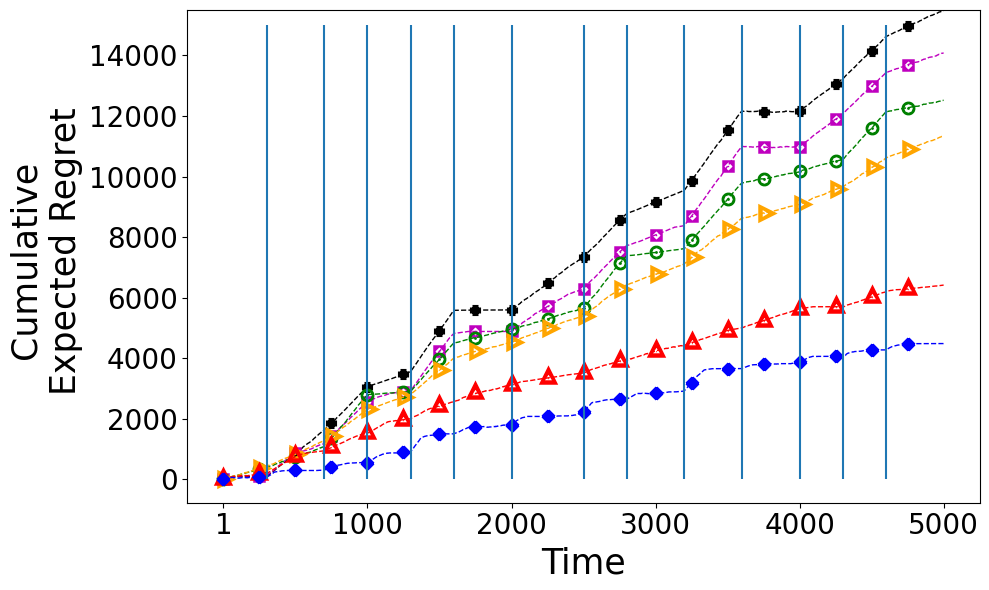

In [148]:
Y1 = aaaa[0:rounds]
Y2 = cccc[0:rounds]
Y3 = dddd[0:rounds]
Y4 = eeee[0:rounds]
Y5 = ffff[0:rounds]
Y6 = bbbb[0:rounds]

###################### saving the final results in a csv file ################
# expected_average_regret_saving=np.zeros((6, Y1.shape[0]))
# expected_average_regret_saving[0,:]=Y1
# expected_average_regret_saving[1,:]=Y2
# expected_average_regret_saving[2,:]=Y3
# expected_average_regret_saving[3,:]=Y4
# expected_average_regret_saving[4,:]=Y5
# expected_average_regret_saving[5,:]=Y6
# np.savetxt(f"cumulative_expected_regret_saving_d_{Delay}.csv", expected_average_regret_saving, delimiter=",")

###############################################################################

fig = plt.figure(figsize=[10, 6])

plt.plot(np.arange(rounds),np.transpose(Y5),'--',color = 'k', linewidth=1, marker = '+', mew = '8', ms='4', markevery=250,label='CTS');
plt.plot(np.arange(rounds),np.transpose(Y3),'--',color = 'm', linewidth=1, marker = 's', mew = '8', ms='1', markevery=250,label='CUCB');
plt.plot(np.arange(rounds),np.transpose(Y2),'--',color = 'g', linewidth=1, marker = '.', mew = '8', ms='4', markevery=250,label='FTRL');
plt.plot(np.arange(rounds),np.transpose(Y4),'--',color = 'orange', linewidth=1, marker = '>', mew = '8', ms='1', markevery=250,label='Random');
plt.plot(np.arange(rounds),np.transpose(Y6),'--',color = 'r', linewidth=1, marker = '^', mew = '8', ms='1', markevery=250,label='SEM-UCB');
plt.plot(np.arange(rounds),np.transpose(Y1),'--',color = 'b', linewidth=1, marker = 'x', mew = '8', ms='4', markevery=250,label='NDC-SEM');



max_y = 0
for array in [Y1, Y2, Y3, Y5]:
    if np.max(array) > max_y:
        max_y = np.max(array)

plt.vlines(change_points[1:], ymin=0, ymax=15000)

#plt.legend();
axis_font = {'fontname':'Arial', 'size':'19'}
plt.xlabel(r'Time', fontsize=25)
plt.xticks([1] + list(plt.xticks()[0][2:-1]), fontsize=20)
plt.ylim(top=15500)
plt.ylabel("Cumulative \n Expected Regret",fontsize=25)
plt.yticks(fontsize=20)
# plt.legend(prop={'size': 18});
plt.tight_layout();
plt.show;
fig.savefig(f"cumulative_expected_regret_d_{Delay}_new.jpg", format = 'jpg', dpi = 300)




### Cumulative instantaneous regret

In [99]:
aaaa = np.cumsum(inst_regret_df['NDC-SEM'])
bbbb = np.cumsum(inst_regret_df['SEM-UCB'])
cccc = np.cumsum(inst_regret_df['FTRL'])
dddd = np.cumsum(inst_regret_df['CUCB'])
eeee = np.cumsum(inst_regret_df['Random'])
ffff = np.cumsum(inst_regret_df['CTS'])


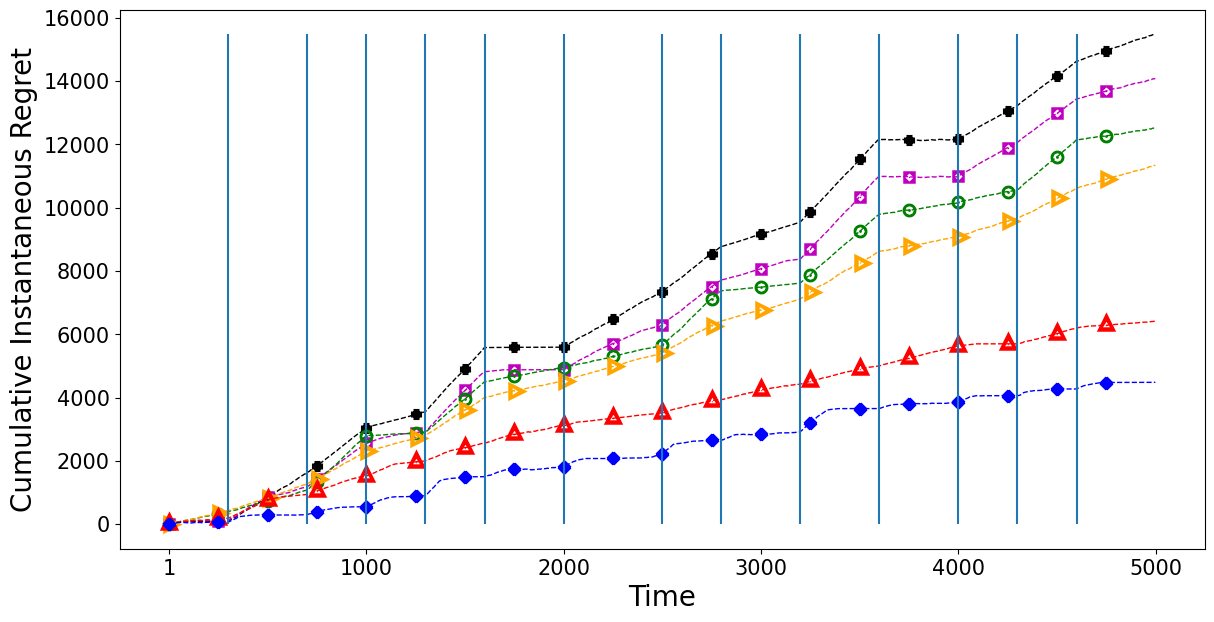

In [100]:
Y1 = aaaa[0:rounds]
Y2 = cccc[0:rounds]
Y3 = dddd[0:rounds]
Y4 = eeee[0:rounds]
Y5 = ffff[0:rounds]
Y6 = bbbb[0:rounds]

fig = plt.figure(figsize=[14, 7])

plt.plot(np.arange(rounds),np.transpose(Y5),'--',color = 'k', linewidth=1, marker = '+', mew = '8', ms='4', markevery=250,label='CTS');
plt.plot(np.arange(rounds),np.transpose(Y3),'--',color = 'm', linewidth=1, marker = 's', mew = '8', ms='1', markevery=250,label='CUCB');
plt.plot(np.arange(rounds),np.transpose(Y2),'--',color = 'g', linewidth=1, marker = '.', mew = '8', ms='4', markevery=250,label='FTRL');
plt.plot(np.arange(rounds),np.transpose(Y4),'--',color = 'orange', linewidth=1, marker = '>', mew = '8', ms='1', markevery=250,label='Random');
plt.plot(np.arange(rounds),np.transpose(Y6),'--',color = 'r', linewidth=1, marker = '^', mew = '8', ms='1', markevery=250,label='SEM-UCB');
plt.plot(np.arange(rounds),np.transpose(Y1),'--',color = 'b', linewidth=1, marker = 'x', mew = '8', ms='4', markevery=250,label='NDC-SEM');



max_y = 0
for array in [Y1, Y2, Y3, Y5]:
    if np.max(array) > max_y:
        max_y = np.max(array)

plt.vlines(change_points[1:], ymin=0, ymax=max_y)

#plt.legend();
# axis_font = {'fontname':'Arial', 'size':'19'}
plt.xlabel('Time', fontsize=20)
plt.xticks([1] + list(plt.xticks()[0][2:-1]), fontsize=15)

plt.ylabel("Cumulative Instantaneous Regret",fontsize=20)
plt.yticks(fontsize=15)
# plt.legend(prop={'size': 18});
plt.show;
fig.savefig(f"cumulative_instantaneous_regret_d_{Delay}.jpg", format = 'jpg', dpi = 300)




### Chosen arms oracle comparison

In [101]:
def oracle_superarms_ratios(actions_by_alg, best_actions_for_interval, intervals):
    """For each interval return how many (relative to oracle) chosen superarms were optimal."""
    assert actions_by_alg.shape[0] == nodes
    time_horizon = actions_by_alg.shape[1]
    
    ratios = np.zeros(len(intervals))
    
    for interval_ind, interval in enumerate(intervals):
        best_action = best_actions_for_interval[interval_ind]
        interval_length = interval[1] - interval[0]
        for t in range(interval[0], interval[1]):
            alg_action = actions_by_alg[:, t]
            
            ratios[interval_ind] += int(np.all(alg_action == best_action[:, 0]))
        print(ratios[interval_ind])
        ratios[interval_ind] /= interval_length
    
    return ratios

In [102]:
def oracle_base_arms_ratios(actions_by_alg, best_actions_for_interval, intervals):
    """For each interval return how many (relative to oracle) chosen base were optimal."""
    assert actions_by_alg.shape[0] == nodes
    time_horizon = actions_by_alg.shape[1]
    
    ratios = np.zeros(len(intervals))
    
    for interval_ind, interval in enumerate(intervals):
        best_action = best_actions_for_interval[interval_ind]
        interval_length = interval[1] - interval[0]
        for t in range(interval[0], interval[1]):
            alg_action = actions_by_alg[:, t]
            
            ratios[interval_ind] += np.count_nonzero(alg_action == best_action[:, 0])
        
        ratios[interval_ind] /= interval_length * nodes
    
    return ratios

In [103]:
all_change_points = change_points + [rounds]

In [104]:
intervals = list(zip(all_change_points, all_change_points[1:]))

In [105]:
intervals

[(0, 300),
 (300, 700),
 (700, 1000),
 (1000, 1300),
 (1300, 1600),
 (1600, 2000),
 (2000, 2500),
 (2500, 2800),
 (2800, 3200),
 (3200, 3600),
 (3600, 4000),
 (4000, 4300),
 (4300, 4600),
 (4600, 5000)]

#### Set which algorithms to plot

In [106]:
labels = ['NDC-SEM', 'SEM-UCB']

In [107]:
all_algorithm_actions_to_plot = [
    all_algorithm_actions[label] for label in labels
]

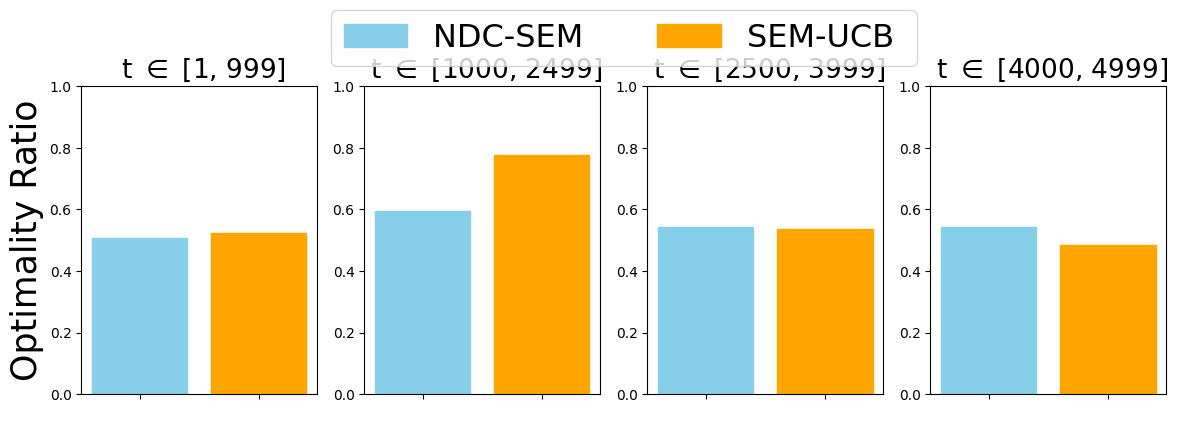

In [ ]:
intervals_1 = [(0, 1000), (1000, 2500), (2500, 4000), (4000,5000)]
fig, axs = plt.subplots(1, len(intervals_1), figsize=(14, 4))
sky_blue_patch = mpatches.Patch(color='skyblue', label='NDC-SEM ')
orange_patch = mpatches.Patch(color='orange', label='SEM-UCB ')
alg_in_interval_raio = np.zeros((len(labels), len(intervals_1)))
for i, alg_action in enumerate(all_algorithm_actions_to_plot):
    alg_in_interval_raio[i, :] = oracle_base_arms_ratios(alg_action, best_action_choice, intervals_1)

for j, interval in enumerate(intervals_1):
    ax = axs[j]
    
    barlist = ax.bar([' ', '  '], alg_in_interval_raio[:, j])
    
    ax.set_title(fr" t $\in$ [{interval[0] or 1}, {interval[1]-1}]", fontsize=19)
    
    if j == 0:
        ax.set_ylabel('Optimality Ratio', fontsize=25)
    # ax.set_xlabel('Policy', fontsize=23)
    # ax.set_xticklabels(labels, rotation=20, fontsize=14)
    
    # plt.setp(ax.xaxis.get_majorticklabels(), fontsize=20, rotation=15)
    # plt.setp(ax.yaxis.get_majorticklabels(), fontsize=20)
    ax.set_ylim(0, 1)
    
    barlist[0].set_color('skyblue')
    barlist[1].set_color('orange')
    # barlist[2].set_color('lightgreen')

plt.legend(prop={'size': 23}, handles=[sky_blue_patch, orange_patch],bbox_to_anchor=(-1.3, 1.4), loc='upper center', ncol = 2)
# plt.tight_layout()
fig.savefig(f"optimal_base_arms_d_{Delay}.jpg", format = 'jpg', dpi = 300)

0
79.0
145.0
77.0
102.0
1
4.0
0.0
0.0
0.0


[0, 300, 700, 1000, 1300, 1600, 2000, 2500, 2800, 3200, 3600, 4000, 4300, 4600]

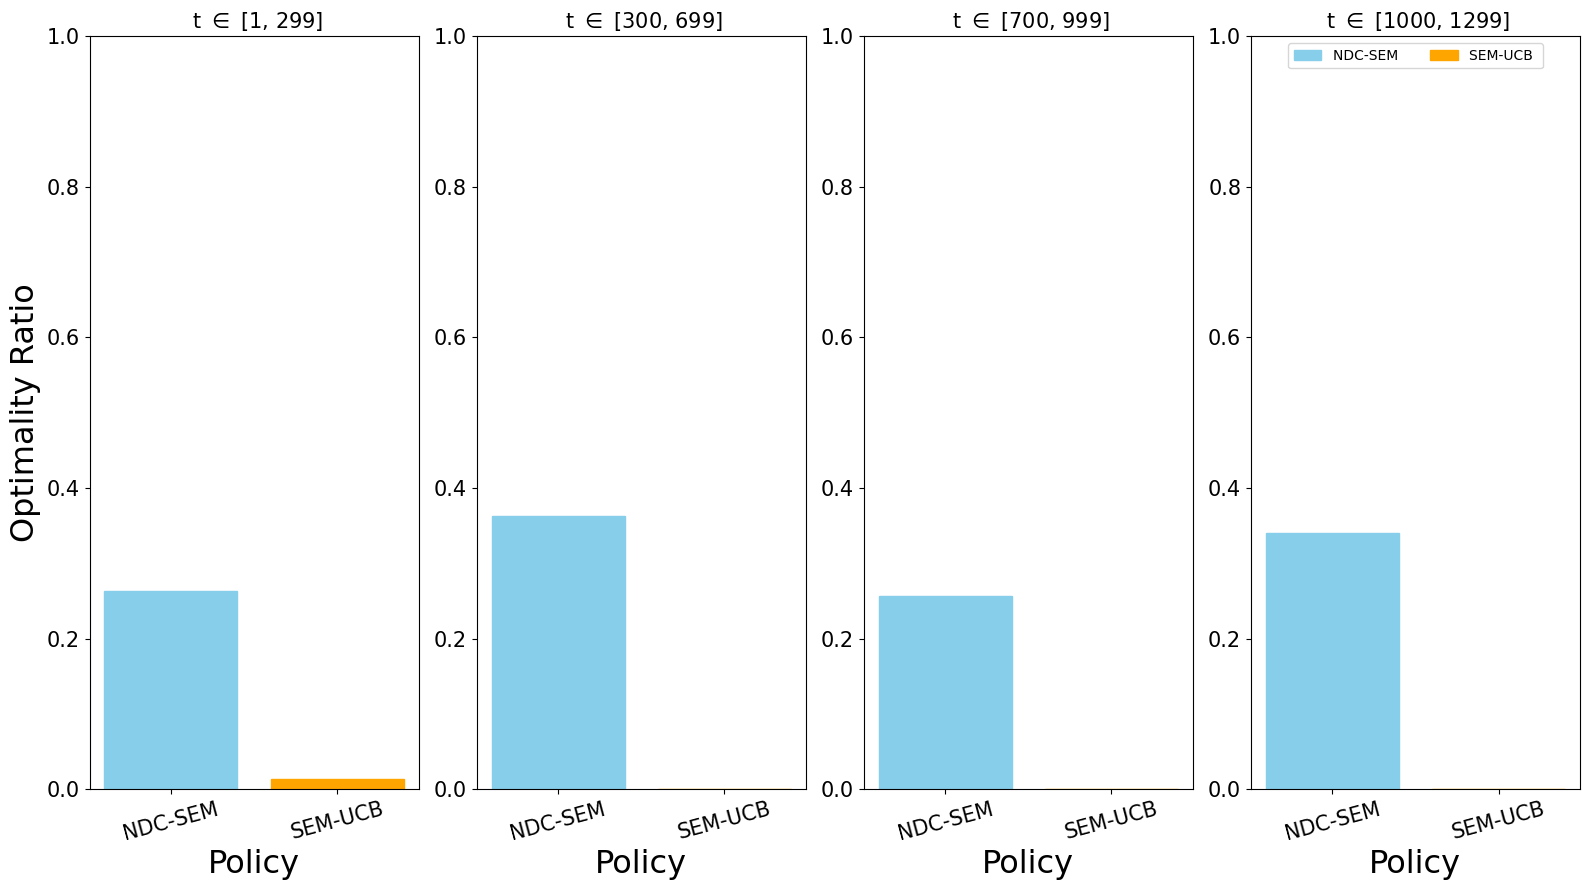

In [192]:

import matplotlib.patches as mpatches

intervals_1 = [(0, 300), (300, 700), (700, 1000), (1000,1300)] 
# intervals_1 = [(0, 300), (300, 700), (700,1000), (1000,1300), (1300, 1600), (1600, 2000), (2000, 2500), (2500, 2800), (2800, 3200), (3200, 3600), (3600, 4000), (4000, 4300), (4300, 4600), (4600, 5000)]
fig, axs = plt.subplots(1, len(intervals_1), figsize=(16, 9))

alg_in_interval_raio = np.zeros((len(labels), len(intervals_1)))
for i, alg_action in enumerate(all_algorithm_actions_to_plot):
    print(i)
    alg_in_interval_raio[i, :] = oracle_superarms_ratios(alg_action, best_action_choice, intervals_1)
sky_blue_patch = mpatches.Patch(color='skyblue', label='NDC-SEM ')
orange_patch = mpatches.Patch(color='orange', label='SEM-UCB ')
for j, interval in enumerate(intervals_1):
    ax = axs[j]
    
    barlist = ax.bar(labels, alg_in_interval_raio[:, j])
    
    ax.set_title(fr" t $\in$ [{interval[0] or 1}, {interval[1]-1}]", fontsize=15)
    
    if j == 0:
        ax.set_ylabel('Optimality Ratio', fontsize=23)
    ax.set_xlabel('Policy', fontsize=23)
    # ax.set_xticklabels(labels, rotation=20, fontsize=14)
    
    if j ==1:
        plt.legend(handles=[sky_blue_patch, orange_patch], loc='upper center', ncol = 2)

    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=15, rotation=15)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=15)
    ax.set_ylim(0, 1)
    barlist[0].set_color('skyblue')
    barlist[1].set_color('orange')
    # barlist[2].set_color('lightgreen')

    
# plt.legend(handles=[sky_blue_patch, orange_patch], bbox_to_anchor=(-0.5, 1.5), loc='upper center', ncol = 2)
plt.tight_layout()
fig.savefig(f"optimal_superarms_d_{Delay}.jpg", format = 'jpg', dpi = 300)
[0, 300, 700, 1000, 1300, 1600, 2000, 2500, 2800, 3200, 3600, 4000, 4300, 4600]

In [132]:
alg_in_interval_raio

array([[0.26333333, 0.058     , 0.0375    , 0.        ],
       [0.01333333, 0.018     , 0.        , 0.        ]])

In [ ]:
print(f"Experiment took {time() - start_ts} s")

Experiment took 393.56349205970764 s


In [ ]:
np.sum(expected_regret)

4135.938607749809

In [ ]:
# regret was 8440.688284345555